# Healthy haematopoiesis scATAC-seq data preprocessing
In this notebook we process the scRNA-seq data from GEO GSE139369 (GSM4138872, GSM4138873, GSM4138874, GSM4138875, GSM4138876,GSM4138877). To run this notebook, place make sure that you have the .RDS objects from these experiments located in in a subfolder called raw in a data folder that is in the same directory as your notebook directory. Then, process the data using 1_scRNA_rds_to_mtx.R 3_rbarcodes_rgenees_rpeaks_to_pylist.py ../../scripts/

## 1. Set up the notebook

In [1]:
# load all packages
import os
import mygene
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from umap import UMAP
from SEMITONES.tfidf import TFIDF
from scipy.io import mmread, mmwrite
from scipy.sparse import vstack, csr_matrix
from scipy.stats import mannwhitneyu as mwu
from sklearn.cluster import dbscan
from sklearn.decomposition import PCA, TruncatedSVD
from goatools.obo_parser import GODag
from goatools.anno.genetogo_reader import Gene2GoReader
from goatools.goea.go_enrichment_ns import GOEnrichmentStudyNS
from goatools.test_data.genes_NCBI_9606_ProteinCoding import GENEID2NT
from goatools.base import download_go_basic_obo, download_ncbi_associations

import rpy2
%load_ext rpy2.ipython
from rpy2.robjects.packages import importr
scran = importr("scran")

/home/hvlot/miniconda3/envs/hcv1/lib/python3.6/site-packages/rpy2/robjects/pandas2ri.py:14: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import Index as PandasIndex


We set the working directory to the interim working directory to make sure we do not make changes to the raw data.

In [2]:
os.chdir("../data/interim/")

We create a custom colour map for downstream visualizations

In [3]:
persianorange = "#d99058"
cplblue2 = "#374350"
chesnut = "#cd5c5c"
rosequartz = "#aa98a9"
oldmauve = "#673147"
oldrose = "#c08081"
antiquefuchsia = "#915c83"
oldlavender = "#796878"
pastelblue = "#aec6cf"
babyblue = "#a1caf1"
glaucous = "#6082b6"
cambridge = "#a3c1ad"
asparagus = "#87a96b"
greyasparagus = "#465945"
arylide = "#e9dc9f"
oldgold = "#d6bf4c"
orangeyellow = "#e5a327"
brass = "#b5a642"
olive = "#808000"
clpblue = "#3e4b59"
lavender = "#e6e6fa"
teal = "#469990"
pink = "#fabebe"
brown = "#a52a2a"
khaki = "#c3b091"
orange = "#e59400"

colors = [khaki, chesnut, brown, orange, arylide, clpblue, persianorange,
          orangeyellow, asparagus, teal, olive, brass, oldgold, greyasparagus,
          cplblue2, glaucous, babyblue, pastelblue, oldmauve, oldlavender,
          antiquefuchsia, rosequartz, oldrose, pink, lavender, greyasparagus]

## 2. Load data
We load the data in ".mtx" formats and index files after processing the raw data in the .RDS files using ../../scripts/1_scRNA_rds_to_mtx.R and ../../scripts/3_rbarcodes_rgenees_rpeaks_to_pylist.py

In [4]:
class scdata(object):
    def __init__(self, name=None, counts=None):
        self.name = name
        self.counts = counts

In [5]:
snames = ["BMMC_D1T1", "BMMC_D1T2",
          "CD34_D2T1", "CD34_D3T1",
          "PBMC_D4T1", "PBMC_D4T2"]

In [6]:
data = {}
for s in snames:
    data[s] = scdata(name=s,
                     counts=mmread("greenleaf_scRNA_{0}.mtx".format(s)))
    data[s].counts = data[s].counts.tocsr()
    data[s].barcodes = []
    with open("greenleaf_scRNA_{0}_barcodes.txt".format(s), "r") as f:
        data[s].barcodes.extend([l.strip("\n") for l in f.readlines()])
    f.close()
    data[s].genes = []
    with open("greenleaf_scRNA_{0}_genes.txt".format(s), "r") as f:
        data[s].genes.extend([l.strip("\n") for l in f.readlines()])
    f.close()

Now, we combine all data into one dataframe

In [7]:
data["combined"] = scdata(name="combined",
                          counts=vstack([data[s].counts for s in snames]
                                       ).tocsr())
data["combined"].barcodes = [i for sub in [data[s].barcodes for s in snames]
                             for i in sub]
data["combined"].genes = data[s].genes

Below, we save the combined data to ../interim/

In [8]:
mmwrite("greenleaf_scRNA_combined.mtx", data["combined"].counts)
with open("greenleaf_scRNA_combined_barcodes.txt", "w") as f:
    for b in data["combined"].barcodes:
        f.write("{0}\n".format(b))
f.close()
with open("greenleaf_scRNA_combined_genes.txt", "w") as f:
    for g in data["combined"].genes:
        f.write("{0}\n".format(g))
f.close()

## 2. Filtering

### a. Check count and read depth
Plot the number of counts per cell, number of genes per cell, and the ratio of the number of genes expressed over the number of counts per cell.

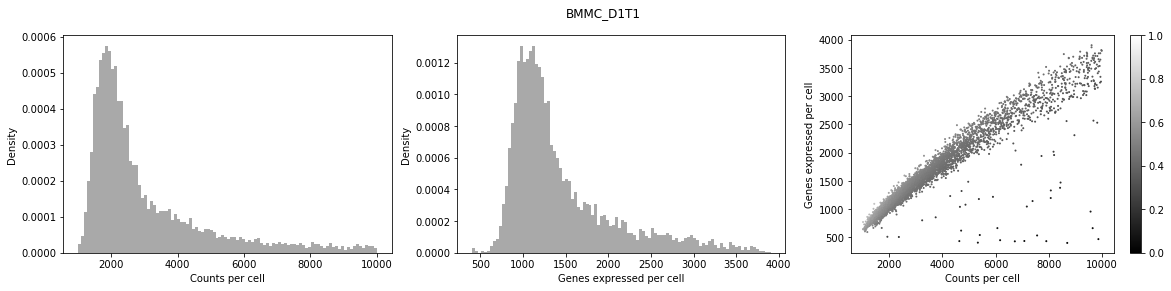

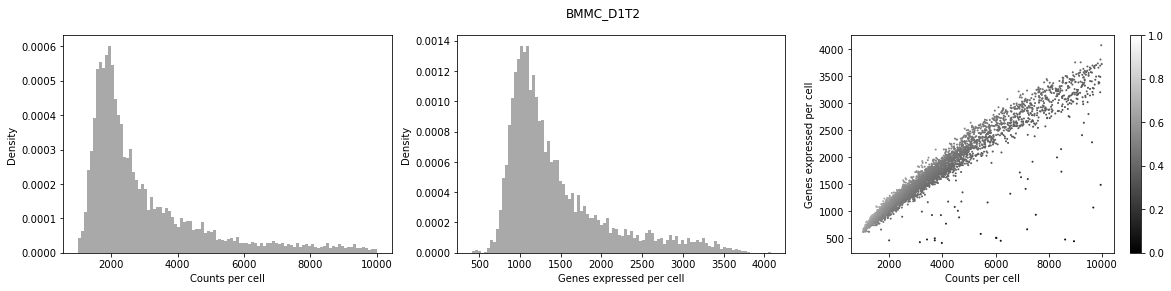

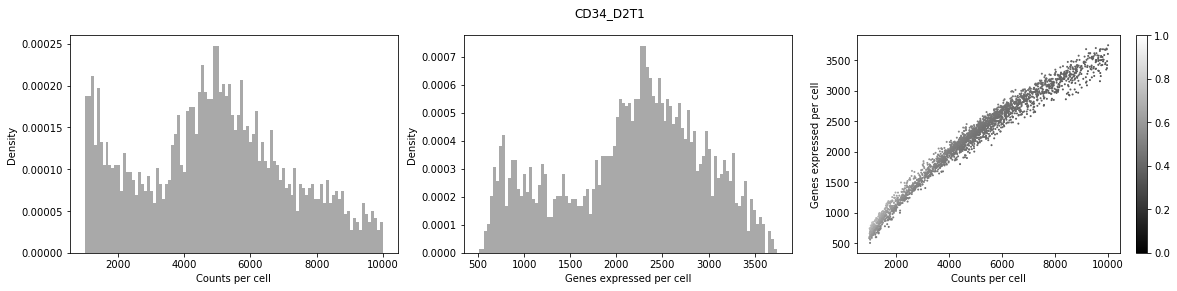

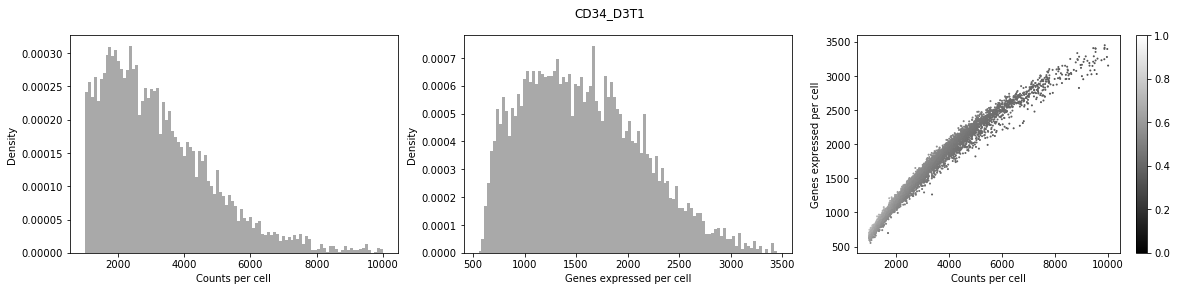

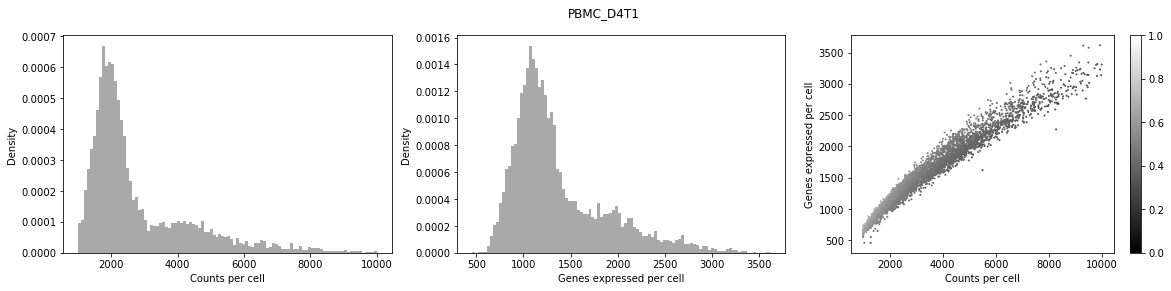

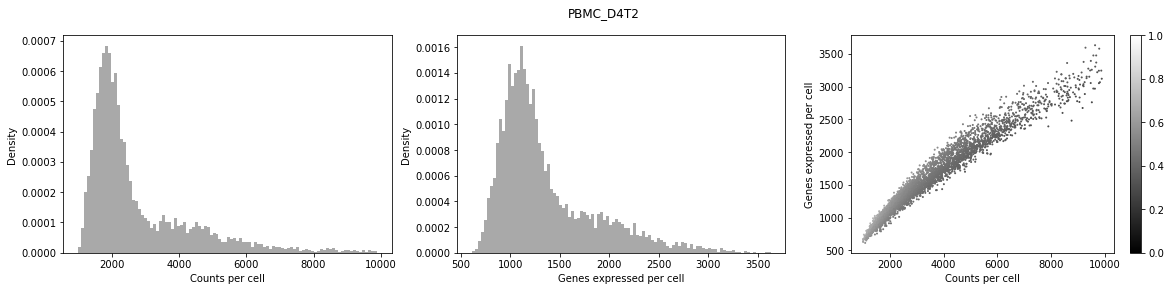

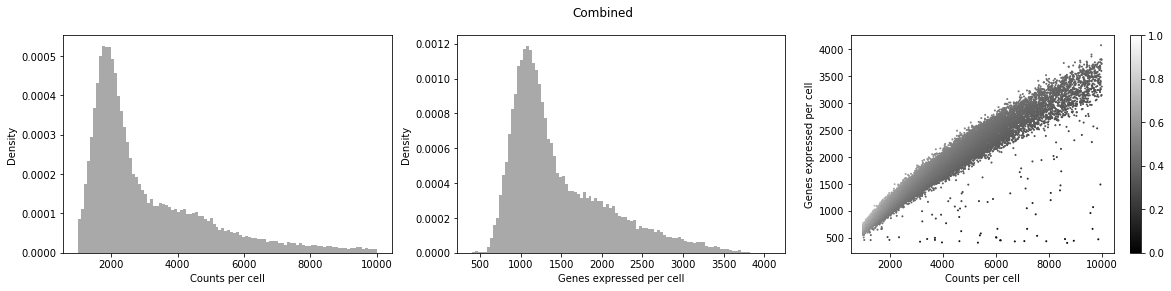

In [9]:
for s in data.keys():
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
    fig.set_figwidth(20)
    fig.suptitle(s) if s in snames else fig.suptitle("Combined")

    data[s].count_depth = np.array(data[s].counts.sum(axis=1)).ravel()
    ax1.hist(data[s].count_depth, bins=100, color="darkgrey", density=True)
    ax1.set_ylabel("Density")
    ax1.set_xlabel("Counts per cell")

    data[s].ngenes_expr = data[s].counts.getnnz(axis=1)
    ax2.hist(data[s].ngenes_expr, bins=100, color="darkgrey", density=True)
    ax2.set_ylabel("Density")
    ax2.set_xlabel("Genes expressed per cell")

    ratio = data[s].ngenes_expr / data[s].count_depth
    _ = ax3.scatter(x=data[s].count_depth, y=data[s].ngenes_expr, c=ratio,
                    cmap="gray", vmin=0, vmax=1, s=1)
    ax3.set_ylabel("Genes expressed per cell")
    ax3.set_xlabel("Counts per cell")
    fig.colorbar(_)

    plt.show()

In some cells, the number of genes expressed is low, while the number of reads is high. We remove these cells by removing any cells for which the ratio between the number of genes expressed over the counts per cell is lower than 0.3. We also see a strong bimodal signature in the first CD34 sample which we will look out for in downstream analysis.

In [10]:
# remove cells and save the filtered matrix in ../data/interim/
for s in data.keys():
    idxs = np.where(data[s].ngenes_expr / data[s].count_depth > 0.3)[0]
    data[s].filtered = data[s].counts[idxs, :]
    data[s].f_barcodes = np.array(data[s].barcodes)[idxs]
    mmwrite("greenleaf_scRNA_{0}_filtered.mtx".format(s), data[s].filtered)
    with open("greenleaf_scRNA_{0}_filtered_barcodes.txt".format(s), "w") as f:
        for b in data[s].f_barcodes:
            f.write("{0}\n".format(b))
    f.close()

## 3. Normalize per sample
Below, we import size factors for normalization that were obtained in ../../scripts/4_scran_normalization_per_sample.py and saved in ../data/interim/ We chose SCRAN for normalization because we expect some cells to be much larger than other in a biologically meaningful manner.

Below, we normalize the counts in each cells using the SCRAN size factors

In [11]:
for s in snames:
    fname = "greenleaf_scRNA_{0}_scran_size_factors.txt".format(s)
    with open(fname, "r") as f:
        data[s].sfs = [float(sf.strip("\n")) for sf in f.readlines()] 
    f.close()
    
    data[s].norm = data[s].filtered / np.array(data[s].sfs).reshape(-1, 1)
    print("Normalization of {0} done".format(s))

Normalization of BMMC_D1T1 done
Normalization of BMMC_D1T2 done
Normalization of CD34_D2T1 done
Normalization of CD34_D3T1 done
Normalization of PBMC_D4T1 done
Normalization of PBMC_D4T2 done


Below, we log-transform the data using an alternative pseudocount as suggested in Lun et al. (2018)

In [12]:
for s in snames:
    smin, smax = np.percentile(data[s].sfs, q=[5, 95])
    delta = np.abs([smin ** -1 - smax ** -1])
    chat = np.max([1, delta])  # rho is 1 so not specified

    data[s].lognorm = np.log(data[s].norm + chat)
    print("Log-transformation of {0} done.".format(s))

Log-transformation of BMMC_D1T1 done.
Log-transformation of BMMC_D1T2 done.
Log-transformation of CD34_D2T1 done.
Log-transformation of CD34_D3T1 done.
Log-transformation of PBMC_D4T1 done.
Log-transformation of PBMC_D4T2 done.


We save the normalized and log-transformed data seperately per sample in ../data/interim/

In [13]:
for s in snames:
    mmwrite("greenleaf_scRNA_{0}_filtered_norm.mtx".format(s),
            data[s].norm)
    mmwrite("greenleaf_scRNA_{0}_filtered_lognorm.mtx".format(s),
            data[s].lognorm)

## 4. Visualize sample UMAPs
We visualize the 2D UMAP over the top 10 PCs over the log-normalized data. The UMAPs are coloured by the cell type annotations taken form the scRNA-seq Hematopoeisis cell x gene Summarized Experiment from https://github.com/GreenleafLab/MPAL-Single-Cell-2019 We also visualize the count depth, mostly to check for downstream influence of the bimodal signature observed for the first CD34 sample.

### a. Plot the initial UMAPs

In [14]:
# load the cell type annotations from wherever it is saved
metadata = pd.read_csv("../external/greenleaf_scRNA_cell_metadata.txt",
                       sep="\t")
# make sure the barcode has the same format as in the raw data
metadata["group_barcode"] = metadata.Group + ":" + metadata.Barcode

/home/hvlot/miniconda3/envs/hcv1/lib/python3.6/site-packages/numba/typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../../../home/hvlot/miniconda3/envs/hcv1/lib/python3.6/site-packages/umap/rp_tree.py", line 135:
@numba.njit(fastmath=True, nogil=True, parallel=True)
def euclidean_random_projection_split(data, indices, rng_state):
^

  state.func_ir.loc))
/home/hvlot/miniconda3/envs/hcv1/lib/python3.6/site-packages/umap/nndescent.py:92: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../..

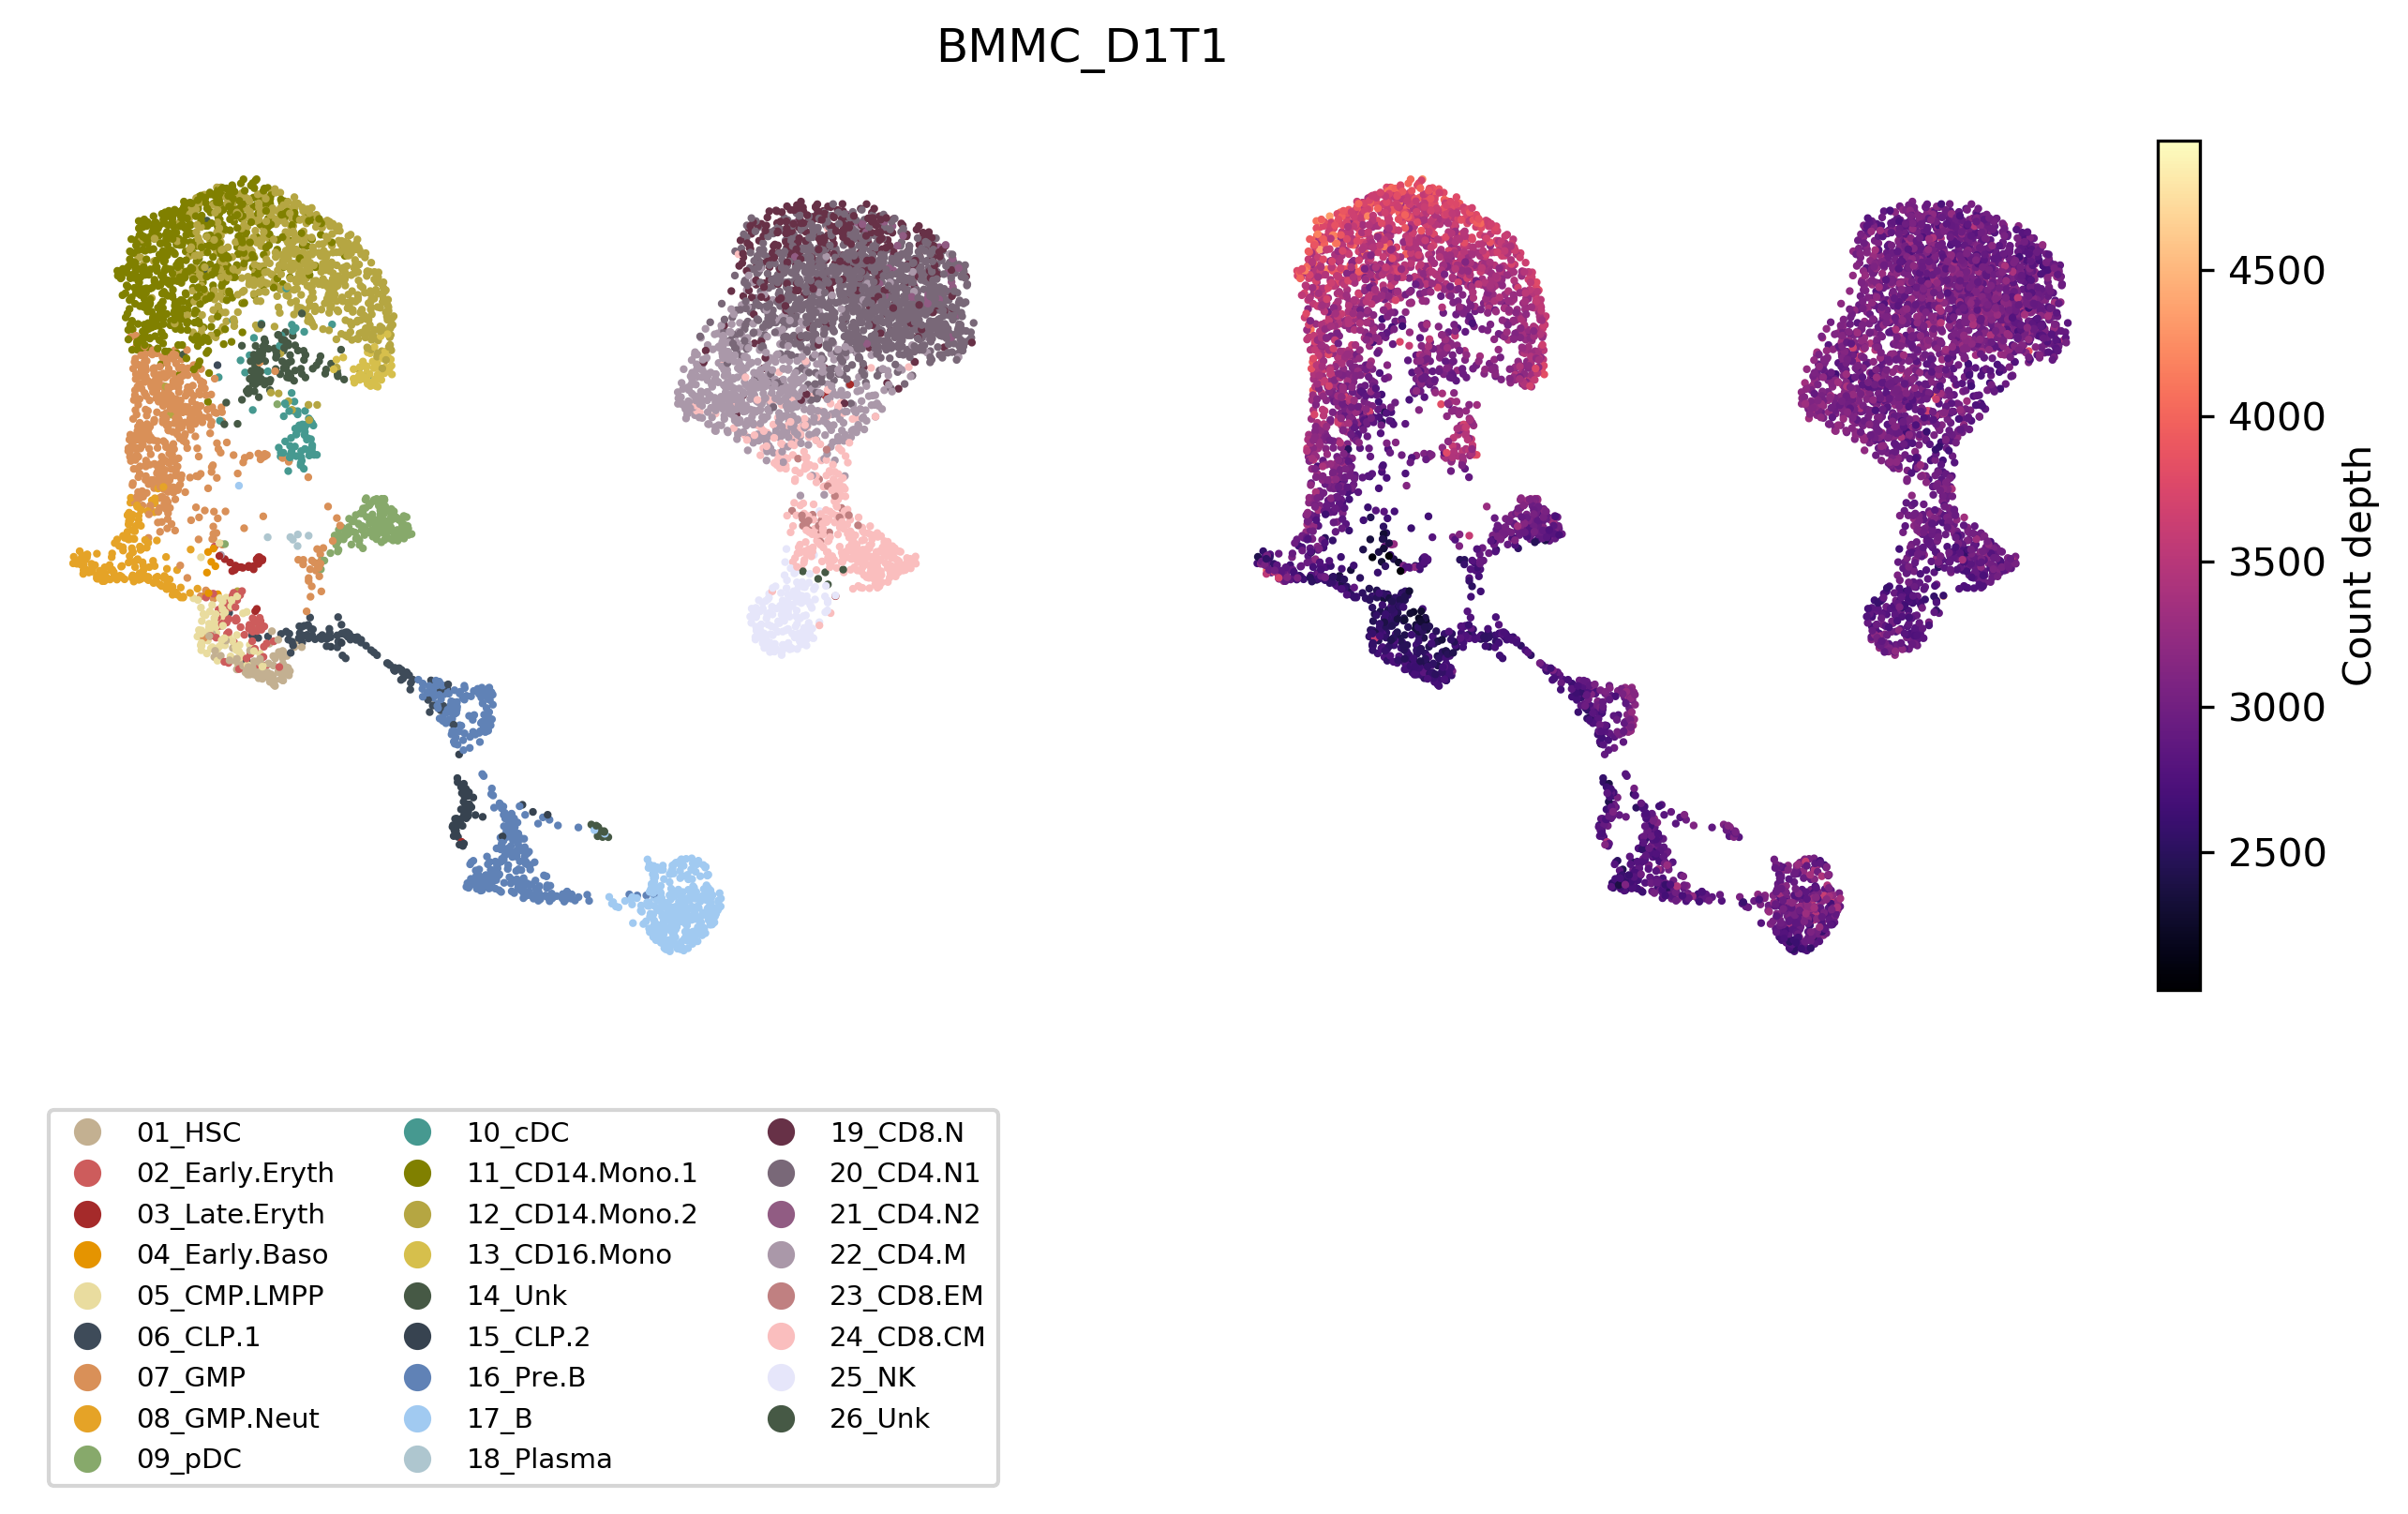

/home/hvlot/miniconda3/envs/hcv1/lib/python3.6/site-packages/numba/typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../../../home/hvlot/miniconda3/envs/hcv1/lib/python3.6/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  state.func_ir.loc))


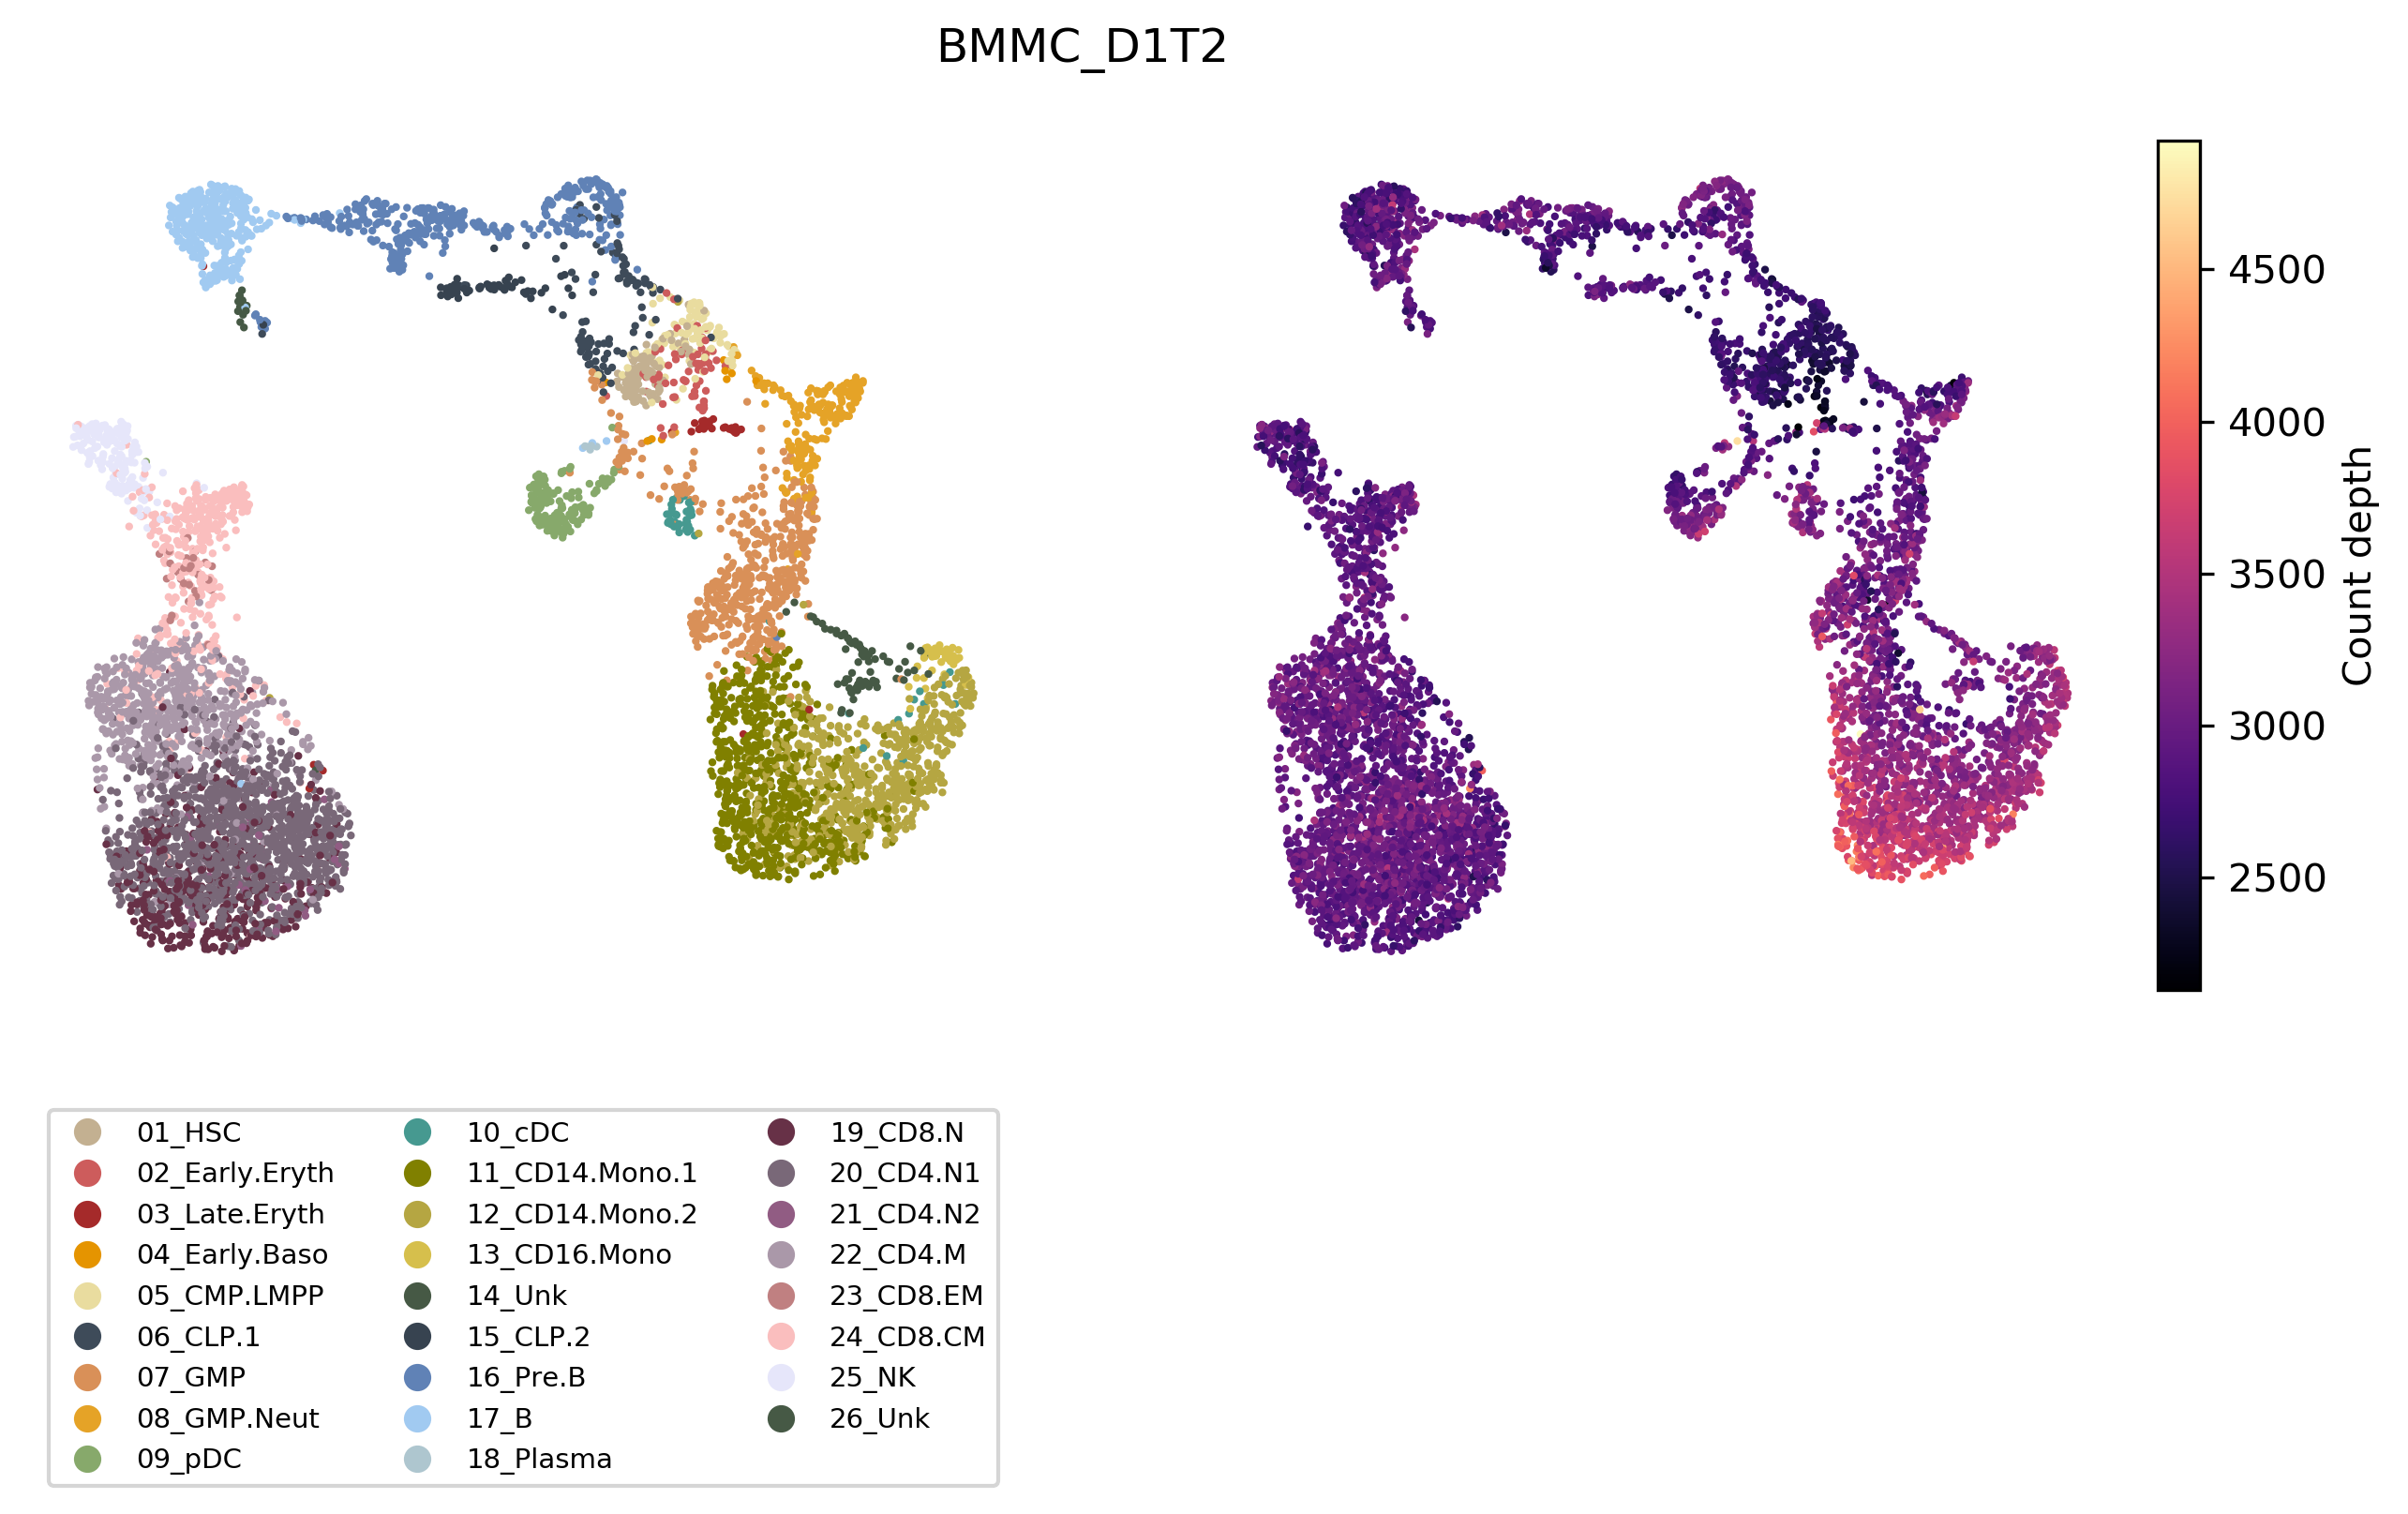

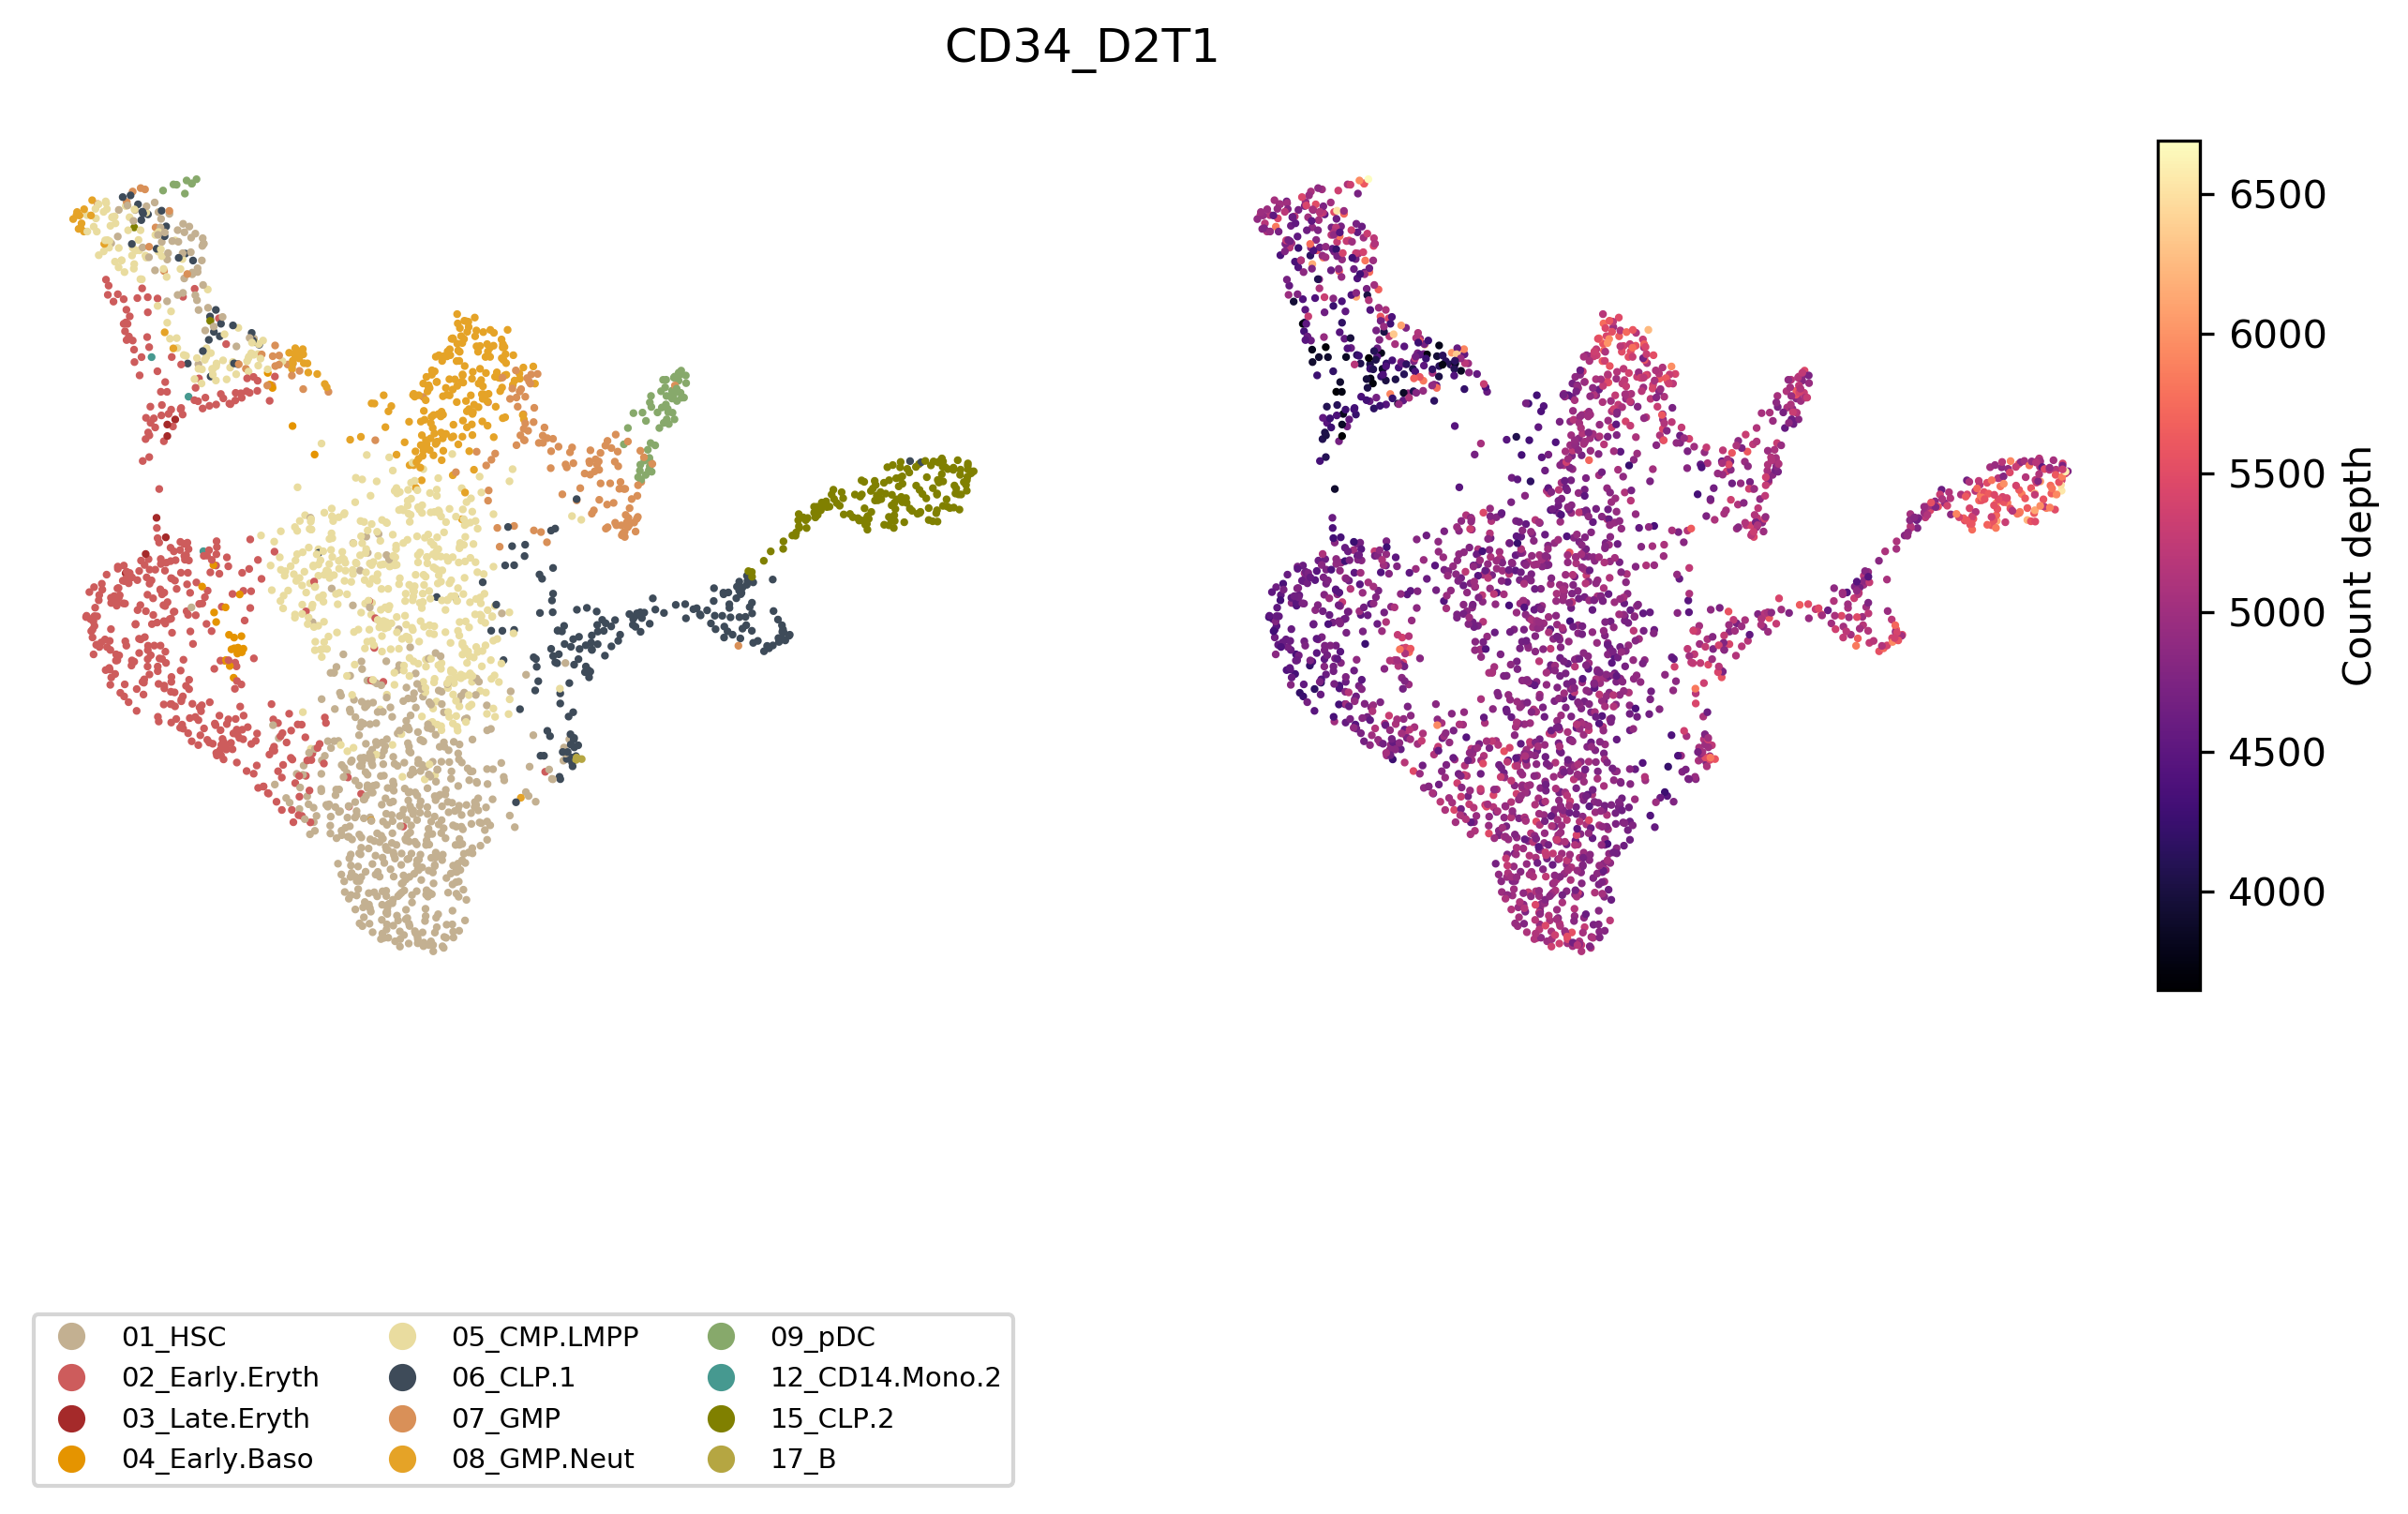

/home/hvlot/miniconda3/envs/hcv1/lib/python3.6/site-packages/numba/typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../../../home/hvlot/miniconda3/envs/hcv1/lib/python3.6/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  state.func_ir.loc))


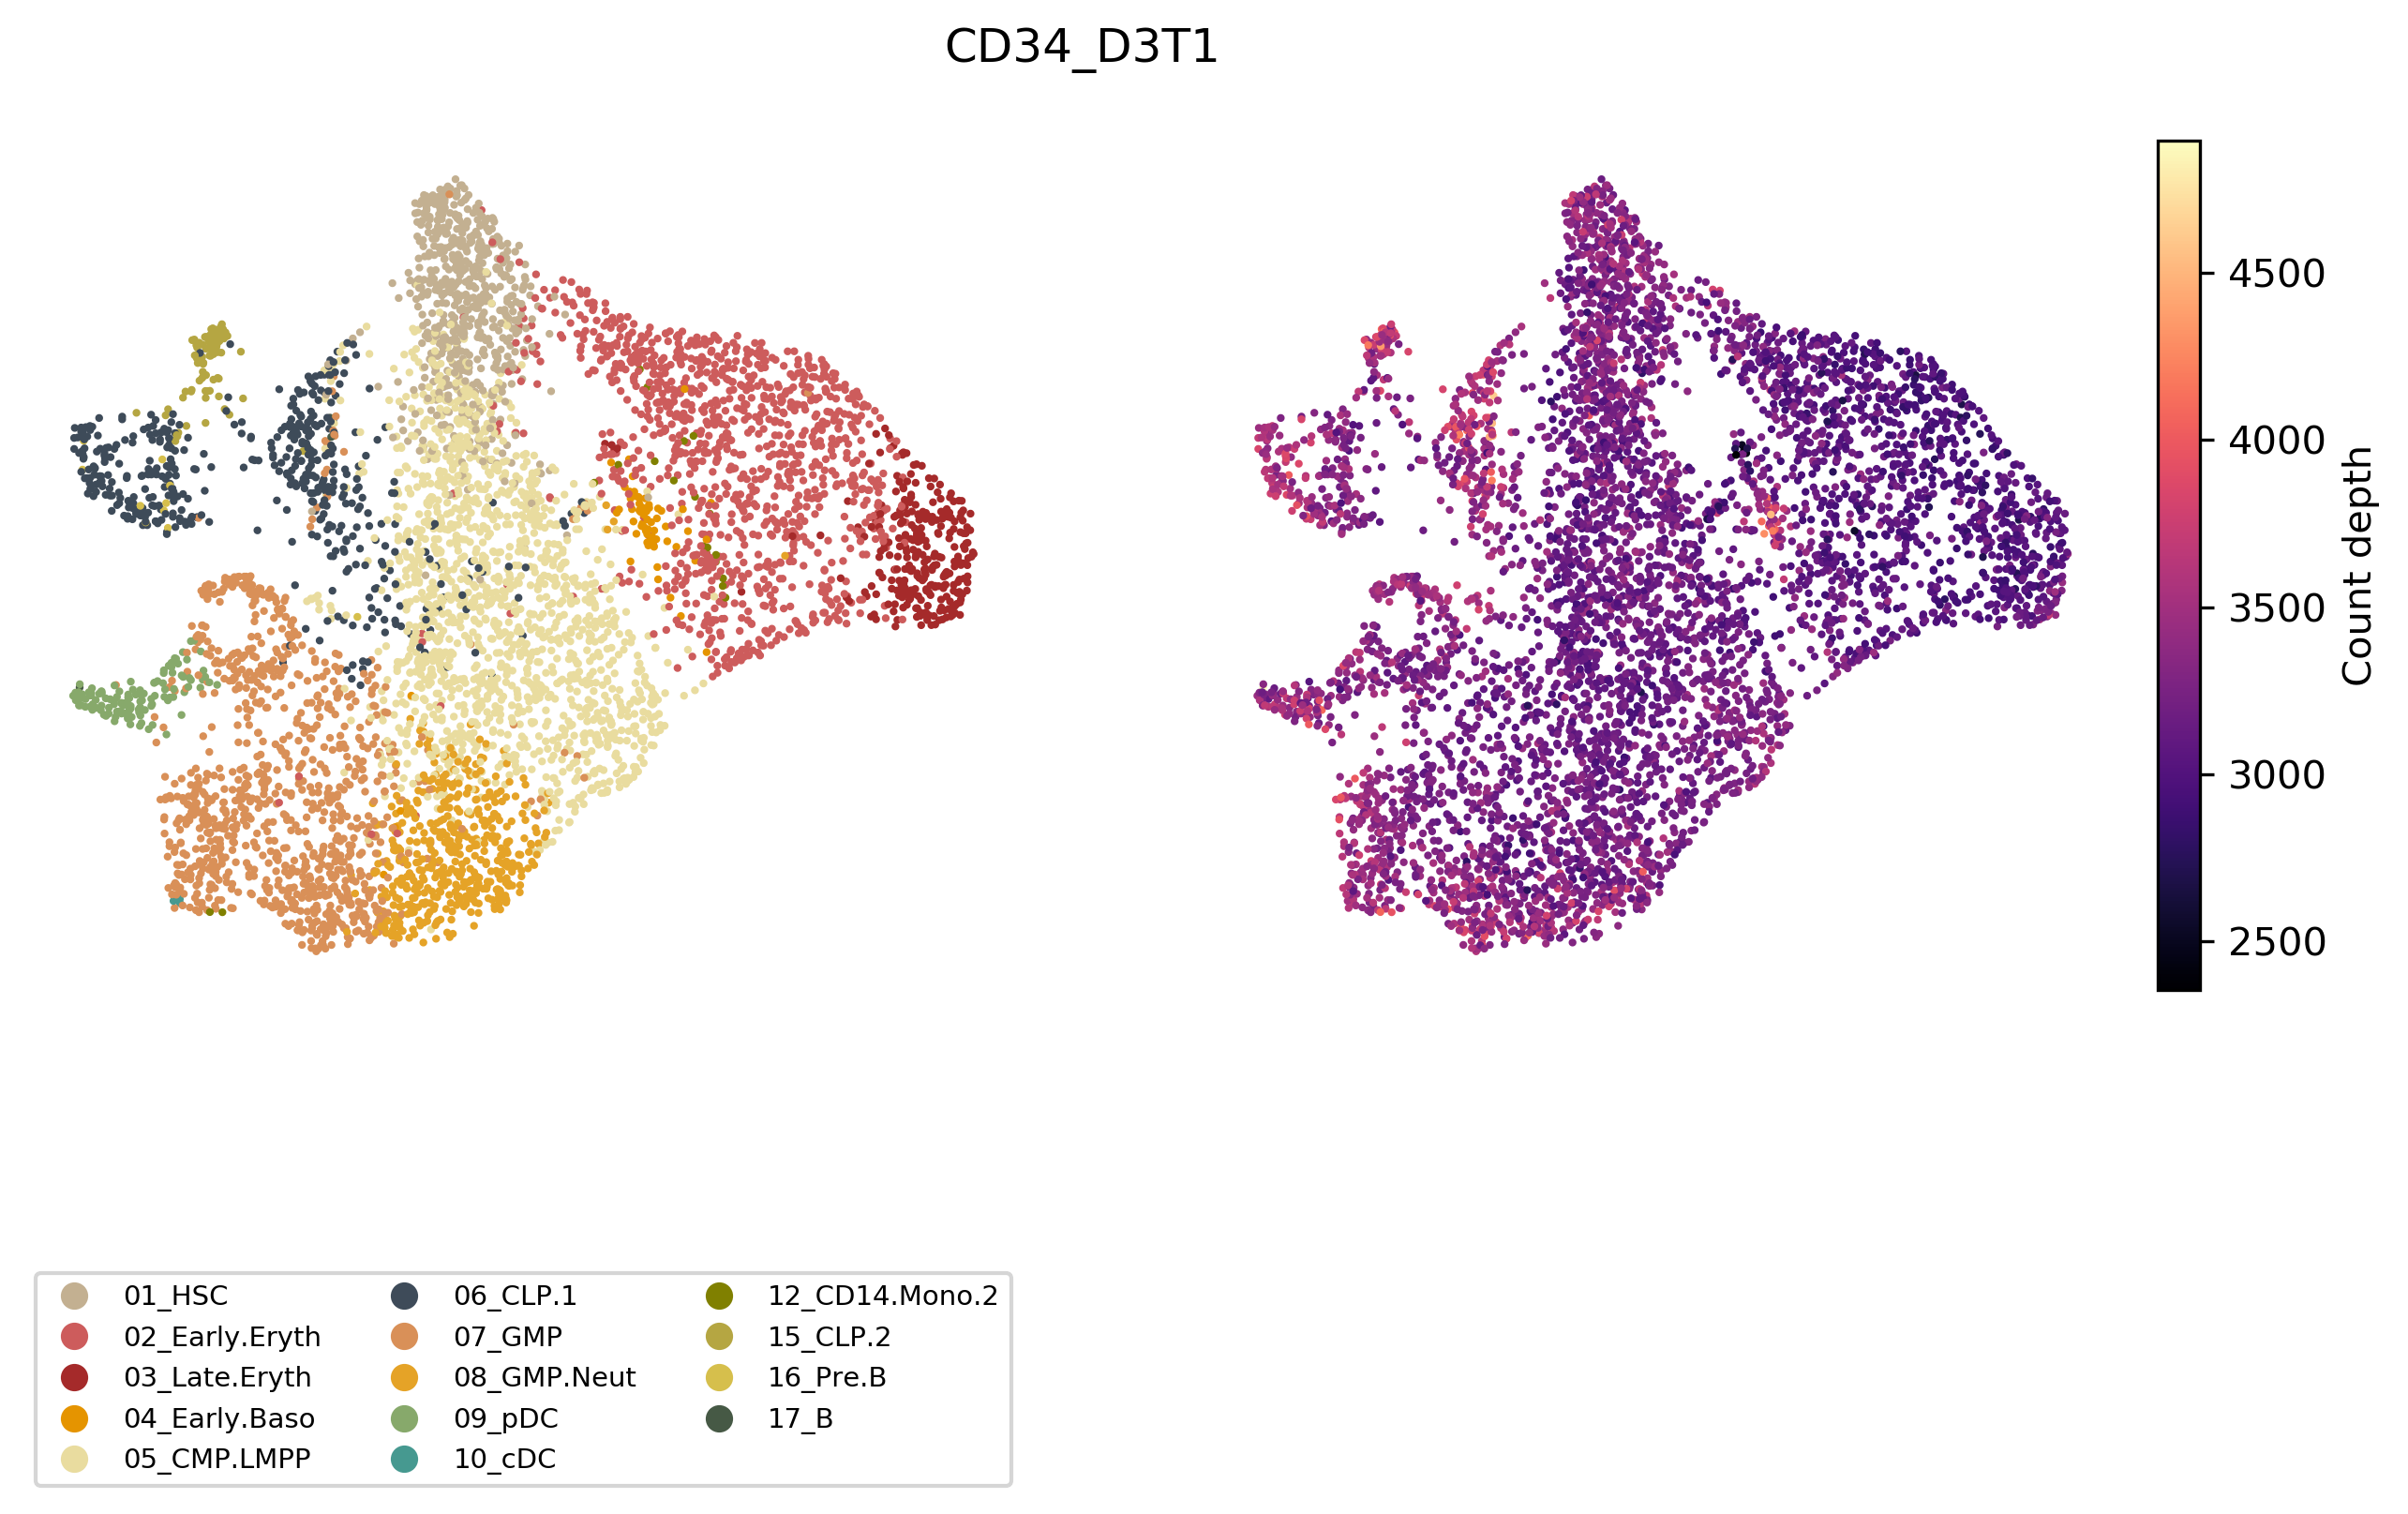

/home/hvlot/miniconda3/envs/hcv1/lib/python3.6/site-packages/numba/typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../../../home/hvlot/miniconda3/envs/hcv1/lib/python3.6/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  state.func_ir.loc))


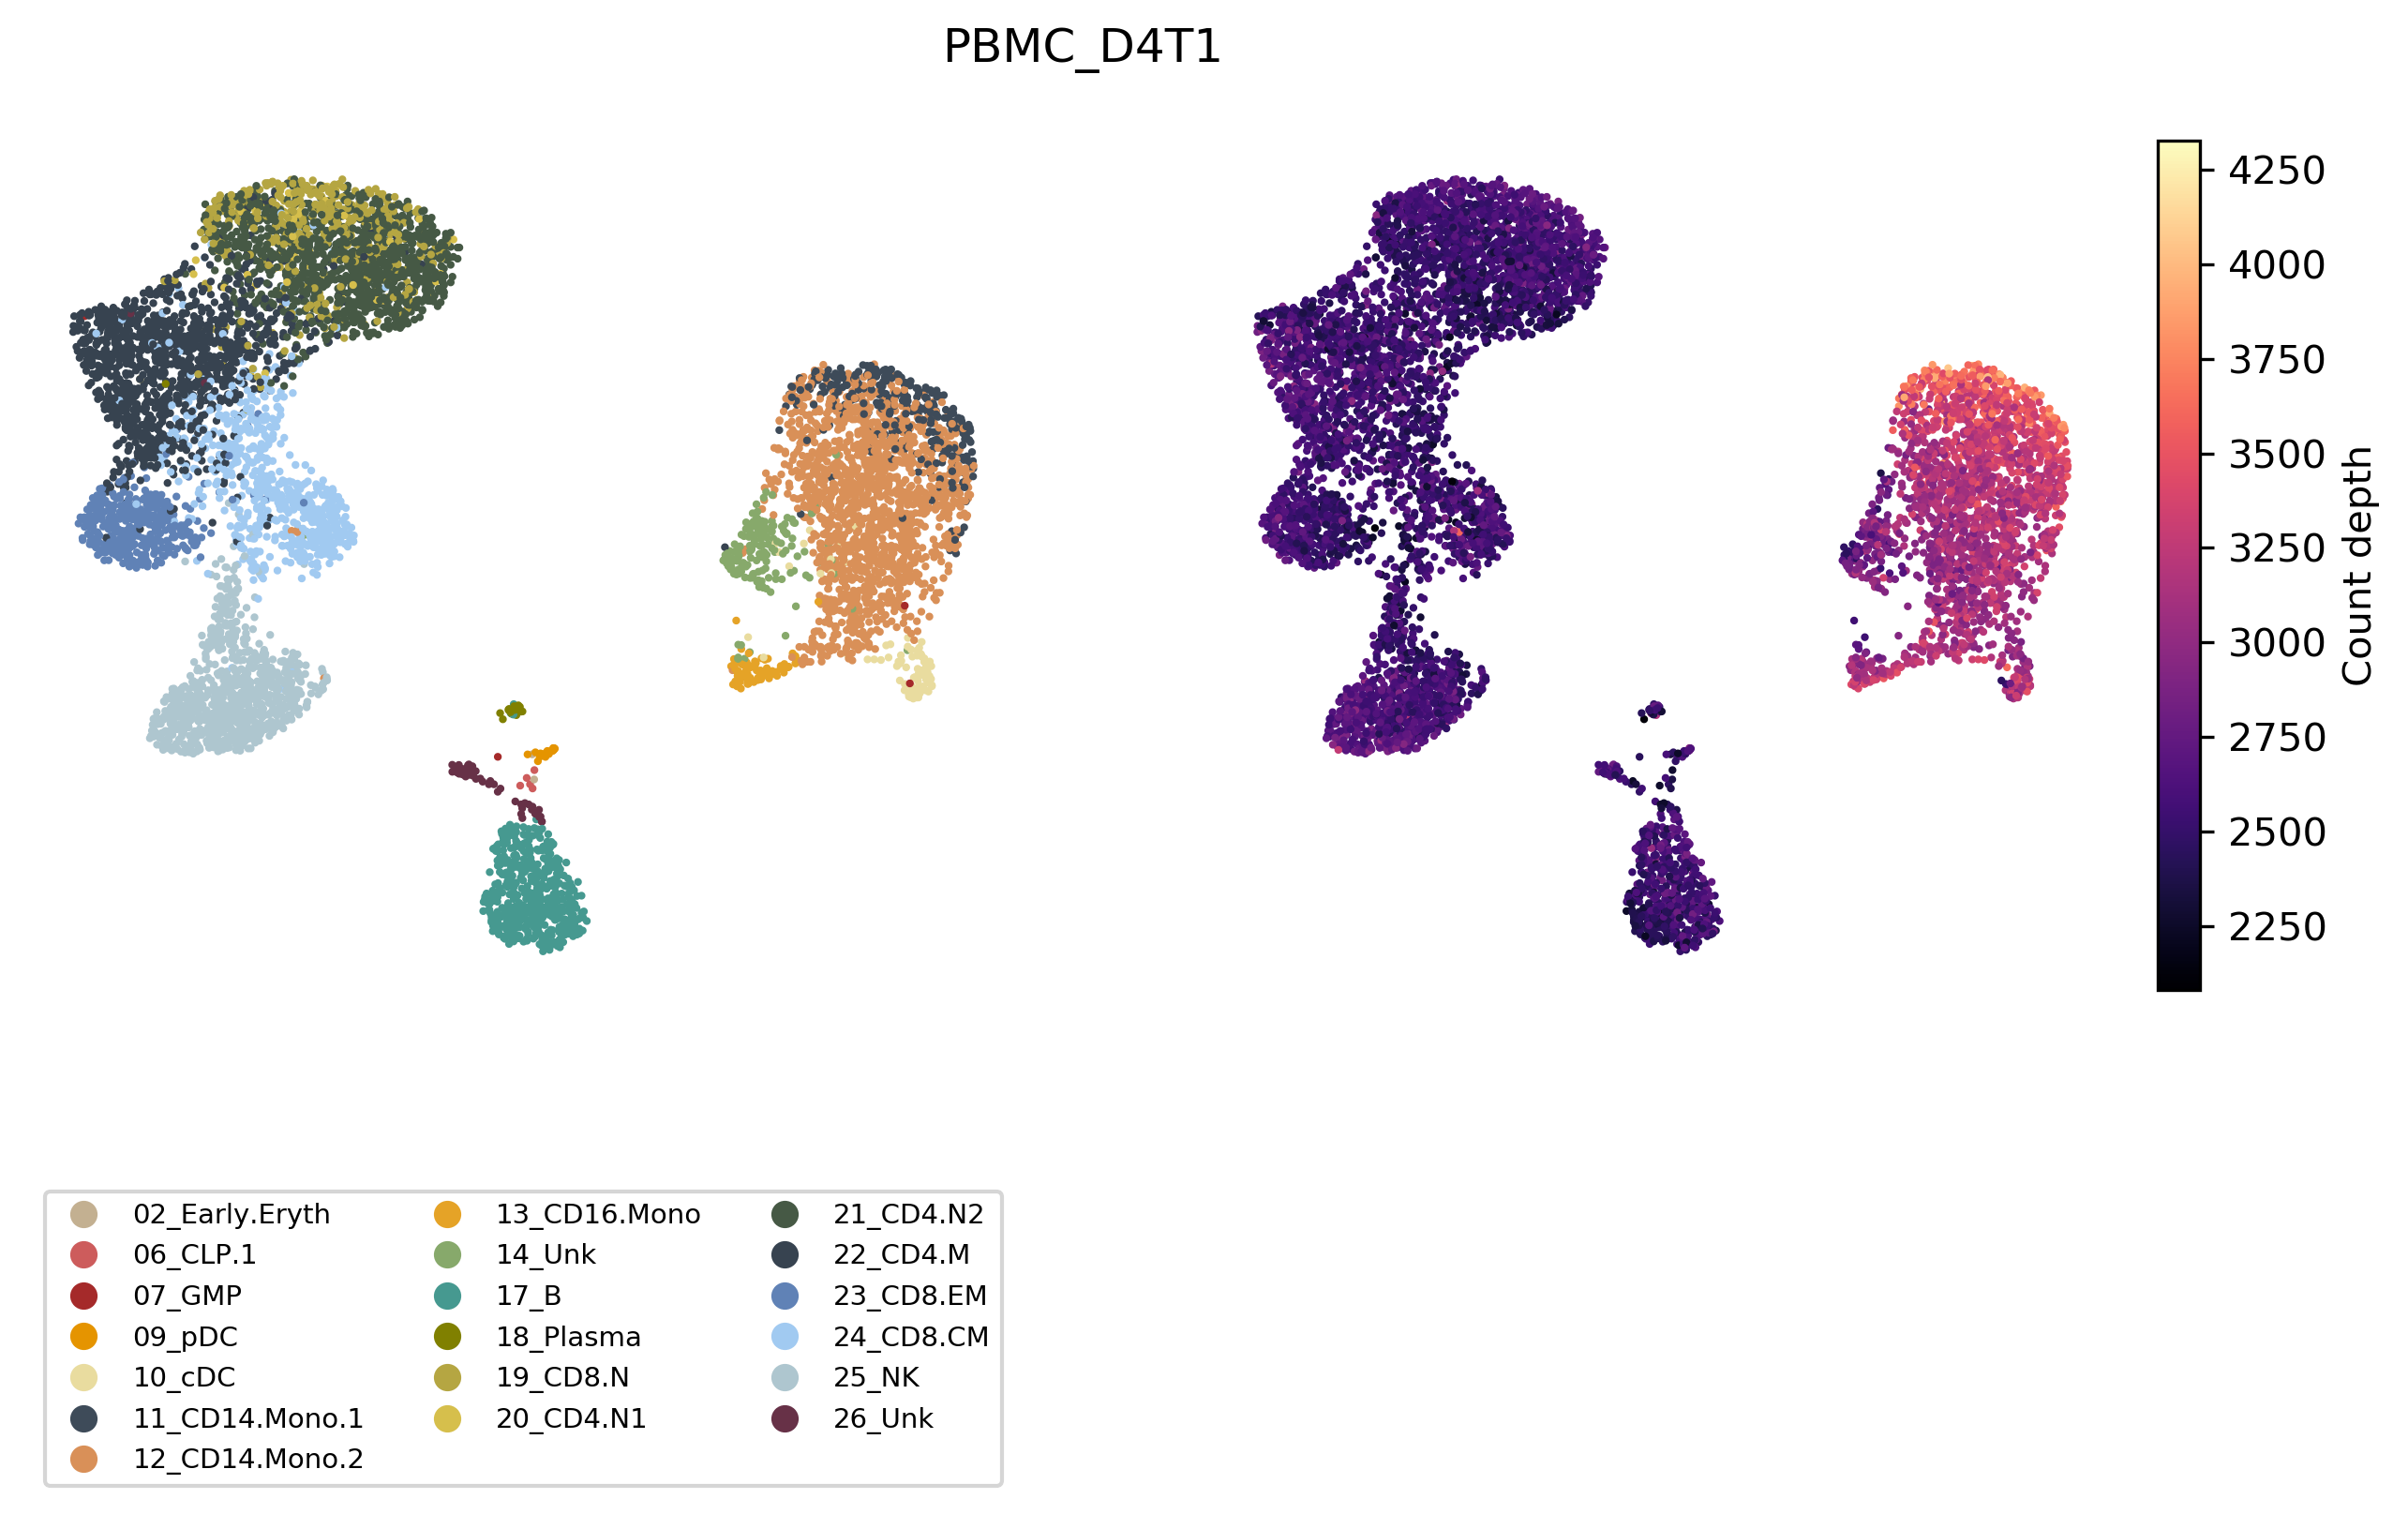

/home/hvlot/miniconda3/envs/hcv1/lib/python3.6/site-packages/numba/typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../../../home/hvlot/miniconda3/envs/hcv1/lib/python3.6/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  state.func_ir.loc))


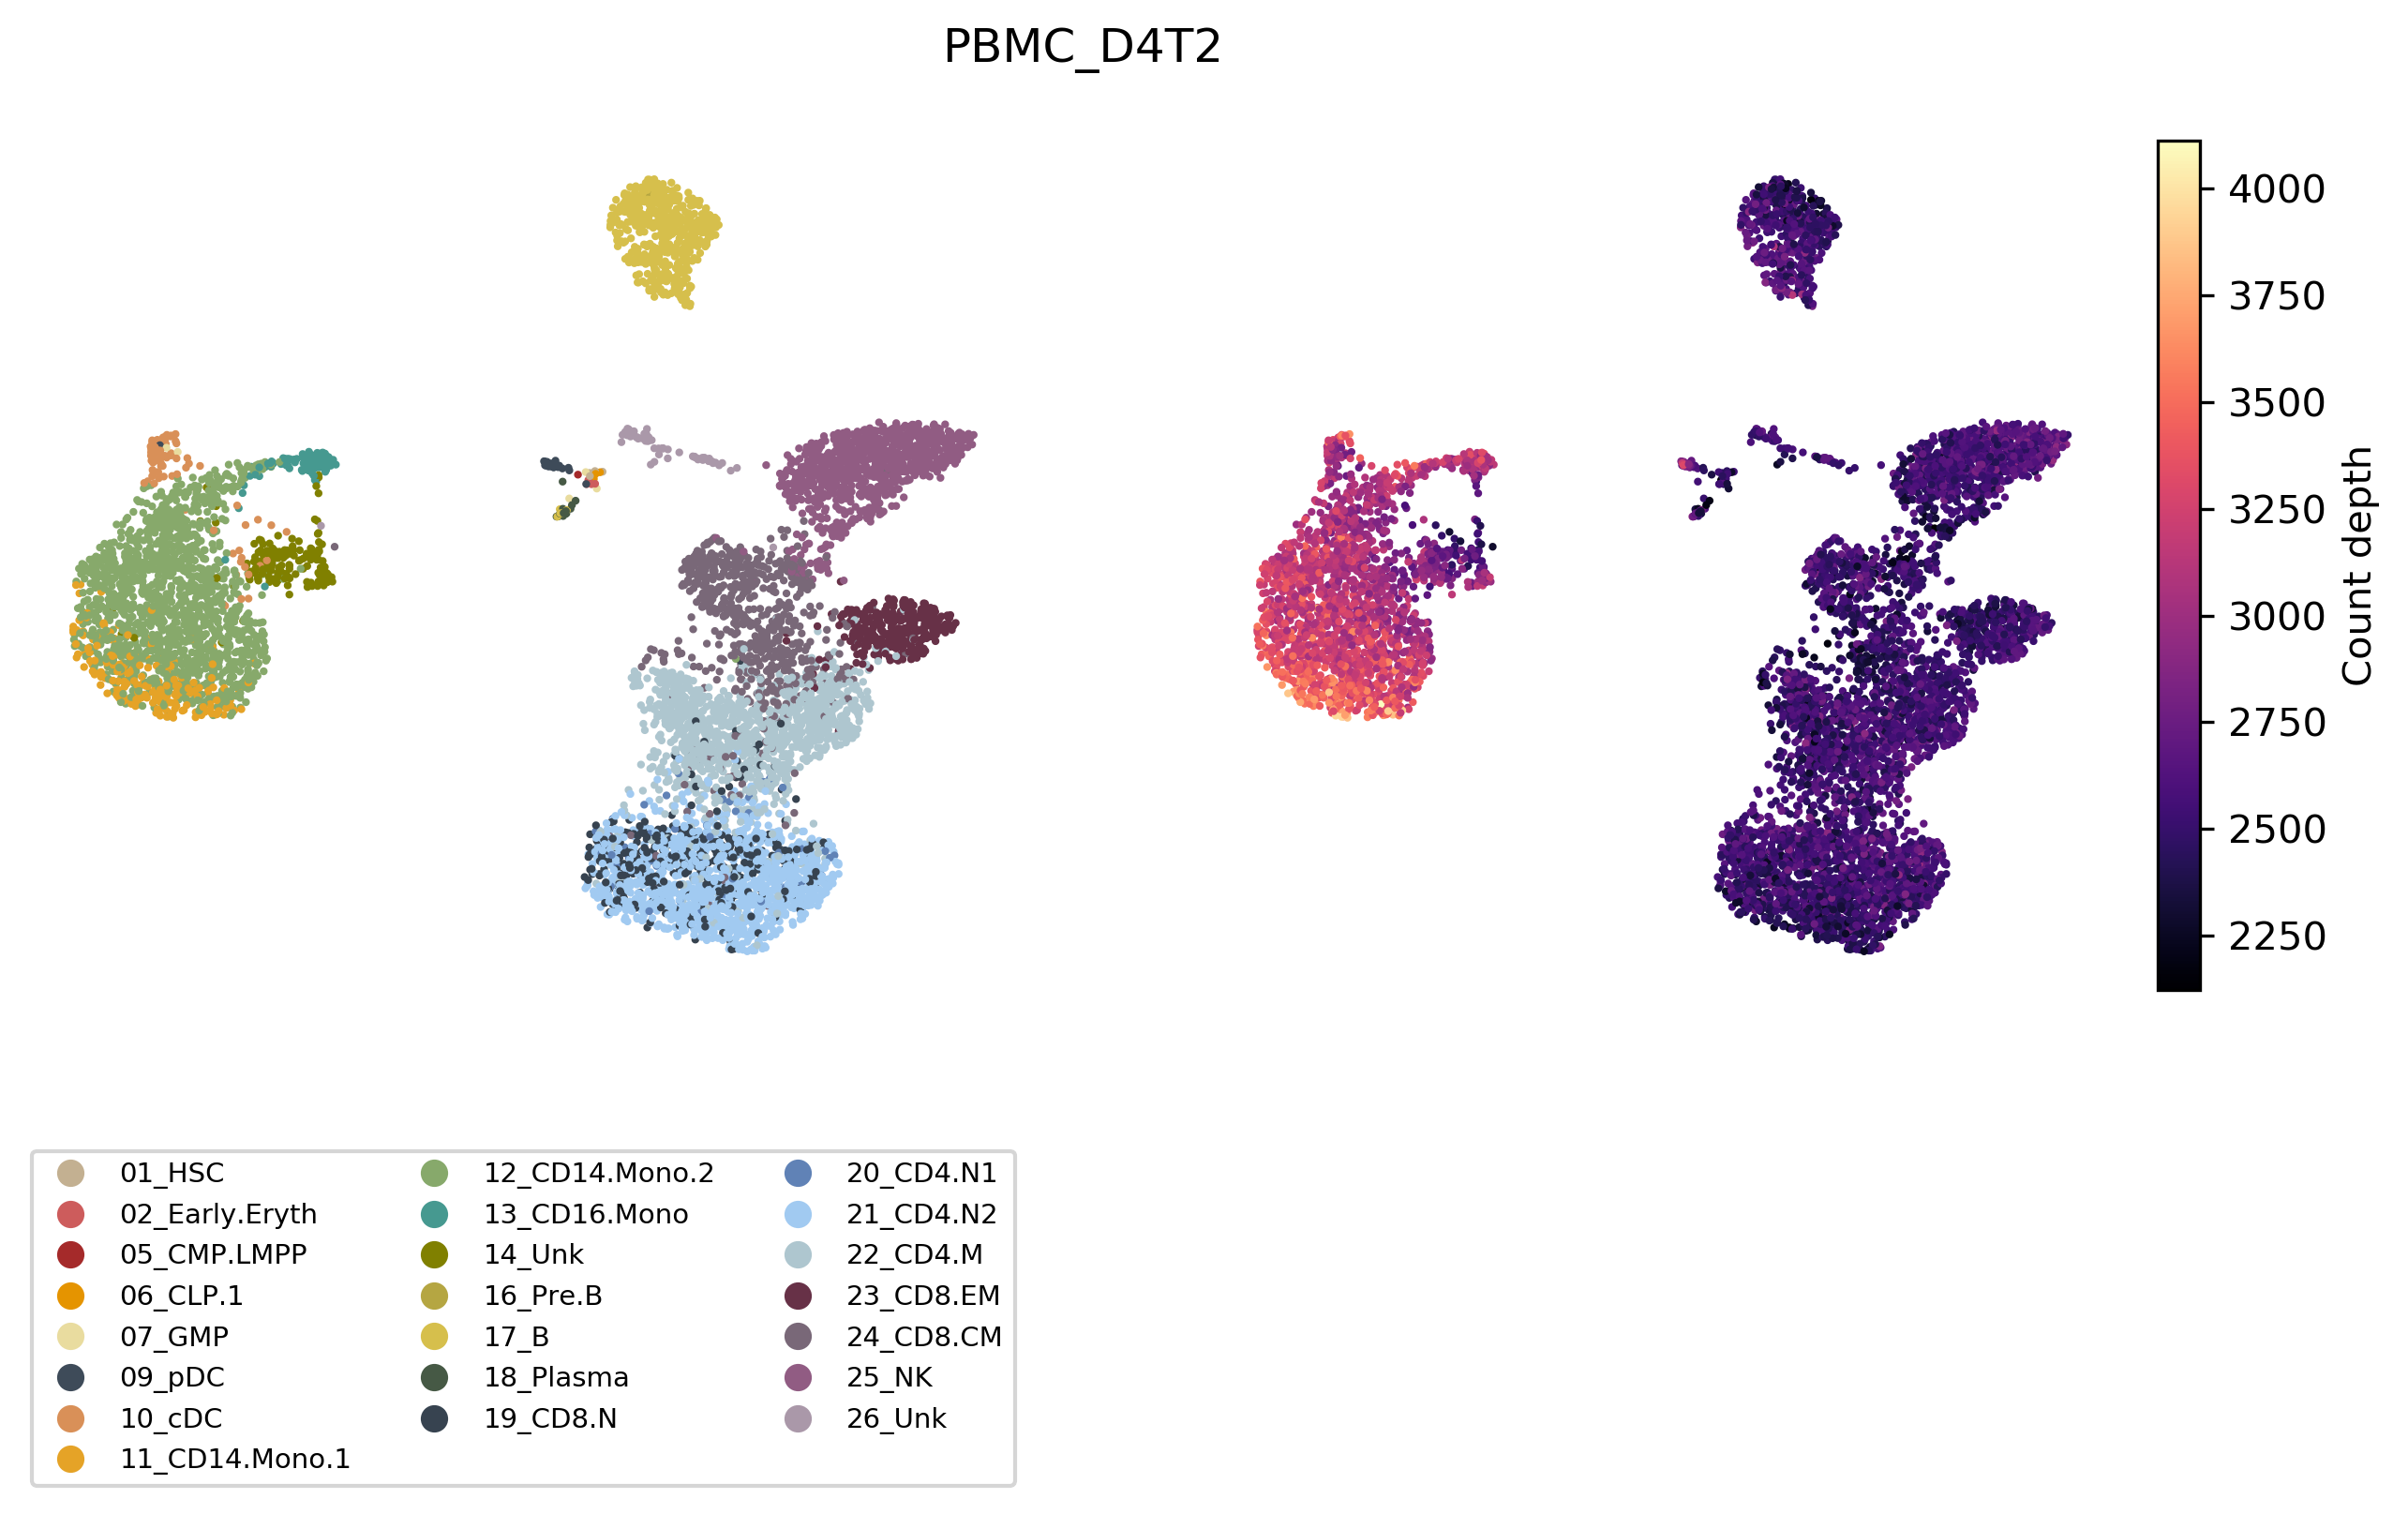

In [15]:
for s in snames:
    # get read count per cell in the normalized data
    n_counts = data[s].norm.sum(axis=1).ravel().tolist()[0]

    # create a color code for the biological labels
    labels = metadata[metadata["group_barcode"].isin(data[s].f_barcodes)
                     ].BioClassification.values
    coldict = dict(zip(np.unique(labels), colors))
    color = labels
    for l, c in coldict.items():
        color = [c if i == l else i for i in color]
    legend = {k: coldict[k] for k in np.unique(labels)}
    marker = [plt.Line2D([0,0], [0,0], color=c, marker="o", ls="")
              for c in legend.values()]

    # do PCA and UMAP
    pca = PCA(n_components=10).fit_transform(data[s].lognorm)
    data[s].umap = UMAP(n_components=2, n_neighbors=25, min_dist=0.5
                       ).fit_transform(pca)
    
    # visualize
    fig, (ax1, ax2) = plt.subplots(1, 2, dpi=300)
    fig.set_figheight(4)
    fig.set_figwidth(10)
    fig.suptitle(s, fontsize=12)

    ax1.scatter(x=data[s].umap[:, 0], y=data[s].umap[:, 1], s=1, c=color)
    ax1.set_ylabel("UMAP 2")
    ax1.legend(marker, legend.keys(), numpoints=0.2, fontsize=7, ncol=3,
               loc="lower center", bbox_to_anchor=(0.5, -0.6))
    ax1.set_ylabel("UMAP 2")
                        
    _ = ax2.scatter(x=data[s].umap[:, 0], y=data[s].umap[:, 1], s=1,
                    c=n_counts, cmap="magma")
    ax2.set_xlabel("UMAP 1")
    
    for ax in [ax1, ax2]:
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        ax.set_frame_on(False)

    cbar = fig.colorbar(_, fraction=0.05)
    cbar.set_label("Count depth")

    plt.show()

We identify a seperate cluster with relatively lower count depth for the first CD34 sample. We will now identify these cells and perform statistical testing of differnetially expressed genes to check which identity these cells might have/why we identify low count depth.

### b. Identify the outlier cells in the first CD34 sample

/home/hvlot/miniconda3/envs/hcv1/lib/python3.6/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys
/home/hvlot/miniconda3/envs/hcv1/lib/python3.6/site-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  
/home/hvlot/miniconda3/envs/hcv1/lib/python3.6/site-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: Adding an axes using the same arguments 

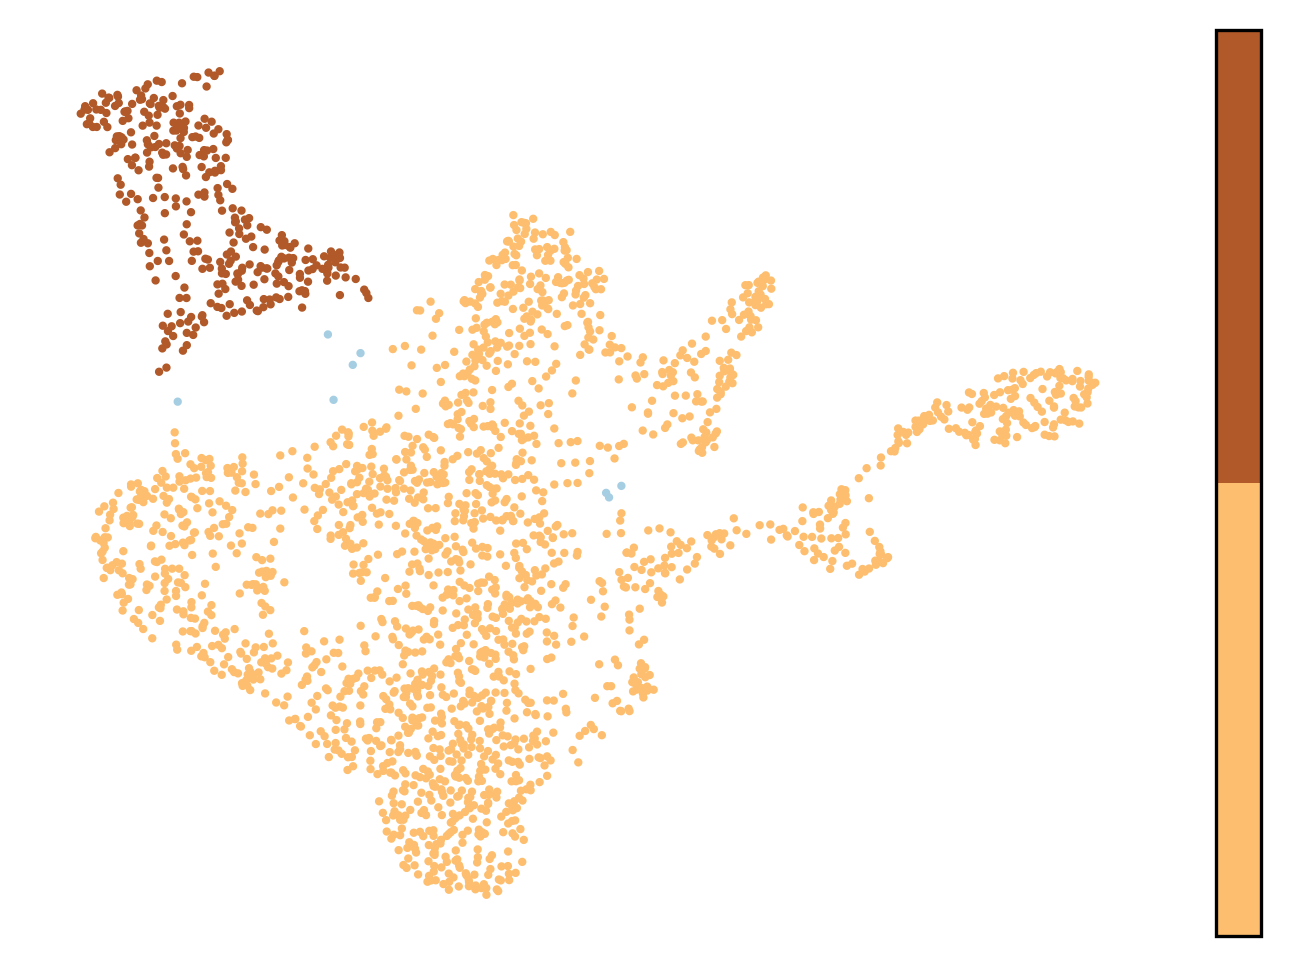

In [16]:
s = "CD34_D2T1"
clusters = dbscan(data["CD34_D2T1"].umap, eps=0.5, metric="euclidean")[1]

plt.figure(dpi=300)
plt.scatter(x=data["CD34_D2T1"].umap[:, 0], y=data["CD34_D2T1"].umap[:, 1],
            s=1, c=clusters, cmap="Paired")
plt.axes().get_xaxis().set_visible(False)
plt.axes().get_yaxis().set_visible(False)
plt.axes().set_frame_on(False)
cbar = plt.colorbar(values=[0, 1], ticks=[0, 1])
cbar.set_ticklabels(["0", "1"])
plt.show()

### c. Mann-Witney U test for differential expression
We perform a one sided test to identify genes that are significantly higher expressed in this outlier cluster with low count depth in the first CD34 sample.

Get a reference set (ref) of the other cells in the data and get the query set of the cells in the outlier cluster.

In [17]:
ref = data["CD34_D2T1"].lognorm[np.where(clusters != 1)[0], :]
query = data["CD34_D2T1"].lognorm[np.where(clusters == 1)[0], :]

In [18]:
len(ref)

2082

Get the Mann-Witney p-values

In [19]:
pvals = []
for i in range(query.shape[1]):
    k1, k2 = query[:, i], ref[:, i]
    try:
        w, p = mwu(k1, k2, alternative="greater")
        pvals.append(p)
    except ValueError:
        pvals.append(np.nan)
mwuvals = pd.DataFrame(pvals, index=data["CD34_D2T1"].genes, columns=["p-value"])

Get critical values for multiple-testing correction

In [20]:
n = len(pvals)
cvals = []
for i, p in enumerate(sorted(pvals)):
    if not str(p) == "nan":
        cvals.append((i / n) * 0.05)
    else:
        cvals.append(np.nan)
mwuvals["c-value"] = cvals

Select differentially expressed genes that have a p-value that is smaller than the critical value for a false discovery rate of 0.05

In [21]:
markers = mwuvals[mwuvals["p-value"] < mwuvals["c-value"]]

Perform GO-enrichment analysis for the marker set

In [22]:
os.chdir("../external/")  # set the directory to save the GO-term data in

In [23]:
obo_fname = download_go_basic_obo()
fin_gene2go = download_ncbi_associations()
objanno = Gene2GoReader(fin_gene2go, taxids=[9606])
goeaobj = GOEnrichmentStudyNS(
        GENEID2NT.keys(), # list of drosophila protein-coding genes
        objanno.get_ns2assc(), # geneid/GO associations
        GODag("go-basic.obo"), # ontologies
        propagate_counts = False,
        alpha = 0.001, # default significance cut-off
        methods = ['fdr_bh']) # defult multipletest correction method

  EXISTS: go-basic.obo
  EXISTS: gene2go
HMS:0:00:03.874295 327,260 annotations, 19,661 genes, 18,330 GOs, 1 taxids READ: gene2go 
go-basic.obo: fmt(1.2) rel(2020-02-21) 47,245 GO Terms

Load BP Gene Ontology Analysis ...
fisher module not installed.  Falling back on scipy.stats.fisher_exact
 80% 16,765 of 20,913 population items found in association

Load CC Gene Ontology Analysis ...
fisher module not installed.  Falling back on scipy.stats.fisher_exact
 85% 17,776 of 20,913 population items found in association

Load MF Gene Ontology Analysis ...
fisher module not installed.  Falling back on scipy.stats.fisher_exact
 80% 16,721 of 20,913 population items found in association


Change gene symbols to gene IDs for compatability with goatools

In [24]:
# create a gene name to gene ID dictionary
mg = mygene.MyGeneInfo()
query = mg.querymany(data["CD34_D2T1"].genes, scopes="symbol", species="human")
name_to_id = dict(zip([query[i]["query"] for i in range(len(query)) if not
                       "notfound" in query[i].keys()],
                      [query[i]["_id"] for i in range(len(query)) if not 
                       "notfound" in query[i].keys()]))


querying 1-1000...done.
querying 1001-2000...done.
querying 2001-3000...done.
querying 3001-4000...done.
querying 4001-5000...done.
querying 5001-6000...done.
querying 6001-7000...done.
querying 7001-8000...done.
querying 8001-9000...done.
querying 9001-10000...done.
querying 10001-11000...done.
querying 11001-12000...done.
querying 12001-13000...done.
querying 13001-14000...done.
querying 14001-15000...done.
querying 15001-16000...done.
querying 16001-17000...done.
querying 17001-18000...done.
querying 18001-19000...done.
querying 19001-20000...done.
querying 20001-20287...done.
Finished.
1440 input query terms found dup hits:
	[('FAM138A', 2), ('FAM87B', 2), ('LINC00115', 2), ('FAM41C', 2), ('TTLL10-AS1', 2), ('LINC01134', 2)
399 input query terms found no hit:
	['FAM213B', 'LINC00982', 'PQLC2', 'MINOS1-NBL1', 'MINOS1', 'YARS', 'ADPRHL2', 'C1orf123', 'CYR61', '
Pass "returnall=True" to return complete lists of duplicate or missing query terms.


In [25]:
# get a query of gene IDs from the gene names
query = [name_to_id[g] for g in markers.index if g in name_to_id.keys()]
query = [int(g) for g in query if not "ENS" in g]  # need to be int for GO

Perform GO-enrichment analysis and use a significance threshold of q-value (Benjamini-Hochberg) < 0.001

In [26]:
goenr = [r.name for r in goeaobj.run_study(query) if r.p_fdr_bh < 0.001]


Run BP Gene Ontology Analysis: current study set of 188 IDs ...
 92%    162 of    176 study items found in association
 94%    176 of    188 study items found in population(20913)
Calculating 12,244 uncorrected p-values using fisher_scipy_stats
  12,244 GO terms are associated with 16,765 of 20,913 population items
   1,178 GO terms are associated with    162 of    188 study items
  METHOD fdr_bh:
       3 GO terms found significant (< 0.001=alpha) (  3 enriched +   0 purified): statsmodels fdr_bh
      10 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run CC Gene Ontology Analysis: current study set of 188 IDs ...
 95%    167 of    176 study items found in association
 94%    176 of    188 study items found in population(20913)
Calculating 1,747 uncorrected p-values using fisher_scipy_stats
   1,747 GO terms are associated with 17,776 of 20,913 population items
     303 GO terms are associated with    167 

In [27]:
goenr

['ATF6-mediated unfolded protein response',
 'protein folding in endoplasmic reticulum',
 'antigen processing and presentation of peptide antigen via MHC class I',
 'membrane',
 'melanosome',
 'integral component of lumenal side of endoplasmic reticulum membrane',
 'endoplasmic reticulum',
 'extracellular exosome',
 'endoplasmic reticulum chaperone complex',
 'cell surface',
 'peptide antigen binding']

The GO-terms are all ER-terms and do not show a particular cell phenotype. Given the low read counts, we will assume these cells are not healthy and remove them from further consideration below.

## 5. Remove the ER-enriched CD34 cluster

We change the directory back to ../data/interim, where we can save data

In [28]:
os.chdir("../interim/")

First, we save the first round of filtered cells using the "with_ER" suffix, in case we wanted to use them later.

In [29]:
mmwrite("greenleaf_scRNA_CD34_D2T1_filtered_with_ER.mtx",
        data["CD34_D2T1"].filtered)
with open("greenleaf_scRNA_CD34_D2T1_filtered_with_ER.txt", "w") as f:
    for b in data["CD34_D2T1"].f_barcodes:
        f.write("{0}\n".format(b))
f.close()

mmwrite("greenleaf_scRNA_combined_filtered_with_ER.mtx",
        data["combined"].filtered)
with open("greenleaf_scRNA_combined_filtered_barcodes_with_ER.txt", "w") as f:
    for b in data["combined"].f_barcodes:
        f.write("{0}\n".format(b))
f.close()

Then, we filter the outlier cluster of cells from the first CD34 sample (CD34_D2T1) from the non-normalized CD34_D2T1 sample and overwrite the old filtered sample. We call the new filtered data and barcodes fitlered2 and f_barcodes2.

In [30]:
data["CD34_D2T1"].filtered2 = data["CD34_D2T1"].filtered[np.where(clusters != 1)[0], :]
data["CD34_D2T1"].f_barcodes2 = data["CD34_D2T1"].f_barcodes[np.where(clusters != 1)[0]]

In [31]:
mmwrite("greenleaf_scRNA_CD34_D2T1_filtered.mtx", data["CD34_D2T1"].filtered2)
with open("greenleaf_scRNA_CD34_D2T1_filtered_barcodes.txt", "w") as f:
    for b in data["CD34_D2T1"].f_barcodes2:
        f.write("{0}\n".format(b))
f.close()

Now, we filter the full dataframe. We first combine all barcodes, using f_barcodes for all but CD34_D2T1, for which we use f_barcodes2 and use those to subset the previously filtered (non-normalized) data.

In [32]:
barcodes = [data[s].f_barcodes if s != "CD34_D2T1" else data[s].f_barcodes2
            for s in snames]  # get all barcodes
data["combined"].f_barcodes2 = [i for sub in barcodes for i in sub]  # unchain all barcodes
idxs = [i for i, v in enumerate(data["combined"].f_barcodes)
        if v in data["combined"].f_barcodes2]  # get the indices for all barcodes in f_barcodes2
data["combined"].filtered2 = data["combined"].filtered[idxs, :]  # subset the filtered data again

Save the second step of filtered data as the standard filtered data.

In [33]:
mmwrite("greenleaf_scRNA_combined_filtered.mtx", data["combined"].filtered2)
fname = "../processed/greenleaf_scRNA_combined_filtered_barcodes.txt"
with open(fname, "w") as f:
    for b in data["combined"].f_barcodes2:
        f.write("{0}\n".format(b))
f.close()

## 6. Normalize the full dataset together
Now we finished quality control of the data, we normalize the combined data using size factors obtained using SCRAN in ../../scripts/5_scran_normalization_combined.py

In [34]:
with open("greenleaf_scRNA_combined_scran_size_factors.txt", "r") as f:
    data["combined"].sfs = [float(sf.strip("\n")) for sf in f.readlines()]
f.close()

In [35]:
sfs = np.array(data["combined"].sfs).reshape(-1, 1)
data["combined"].norm = data["combined"].filtered2 / sfs

Save the normalized data into the ../processed/ data folder

In [36]:
mmwrite("../processed/greenleaf_scRNA_combined_norm.mtx",
        csr_matrix(data["combined"].norm))

## 7. Dimensionality reduction and normalization

In [85]:
# make sure you can just load the normalized data here if needed
fname = "../processed/greenleaf_scRNA_combined_norm.mtx"
data["combined"].norm = mmread(fname)
data["combined"].norm = csr_matrix(data["combined"].norm)

In [43]:
# make sure you can load the barcodes of the final filtered data here if needed
fname = "../processed/greenleaf_scRNA_combined_filtered_barcodes.txt"
with open(fname, "r") as f:
    data["combined"].f_barcodes2 = [b.strip("\n") for b in f.readlines()]
f.close()

We now remove any genes that are not expressed after filtering

In [88]:
idxs = np.where(data["combined"].norm.getnnz(axis=0) > 0)[0]
norm = data["combined"].norm[:, idxs]
data["combined"].norm = norm
del norm

Then, we perform Latent Semantic Indexing by first performing term frequency - inverse document frequency transformation and then performing singular value decomposition to obtain the top 50 principal components. We save both the TF-IDF values and the SVD reduction to an .mtx file.

In [91]:
data["combined"].tfidf = TFIDF(data["combined"].norm)
mmwrite("greenleaf_scRNA_combined_tfidf.mtx", data["combined"].tfidf)

In [92]:
data["combined"].svd = TruncatedSVD(n_components=50
                                   ).fit_transform(data["combined"].tfidf)
mmwrite("../processed/greenleaf_scRNA_combined_svd50.mtx",
        data["combined"].svd)

Then, we perform UMAP reduction to get our data into the 2D space. We save the final UMAP to a numpy .npy file. We choose the UMAP parameters so that we see reasonable seperability of the annotations provided in the original data publication metadata.

In [98]:
data["combined"].umap = UMAP(n_components=2, n_neighbors=30,
                             min_dist=0.3, random_state=42
                            ).fit_transform(data["combined"].svd)
np.save("../processed/greenleaf_scRNA_combined_umap.npy",
        data["combined"].umap)

/home/hvlot/miniconda3/envs/hcv1/lib/python3.6/site-packages/numba/typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../../../home/hvlot/miniconda3/envs/hcv1/lib/python3.6/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  state.func_ir.loc))


/home/hvlot/miniconda3/envs/hcv1/lib/python3.6/site-packages/ipykernel_launcher.py:19: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


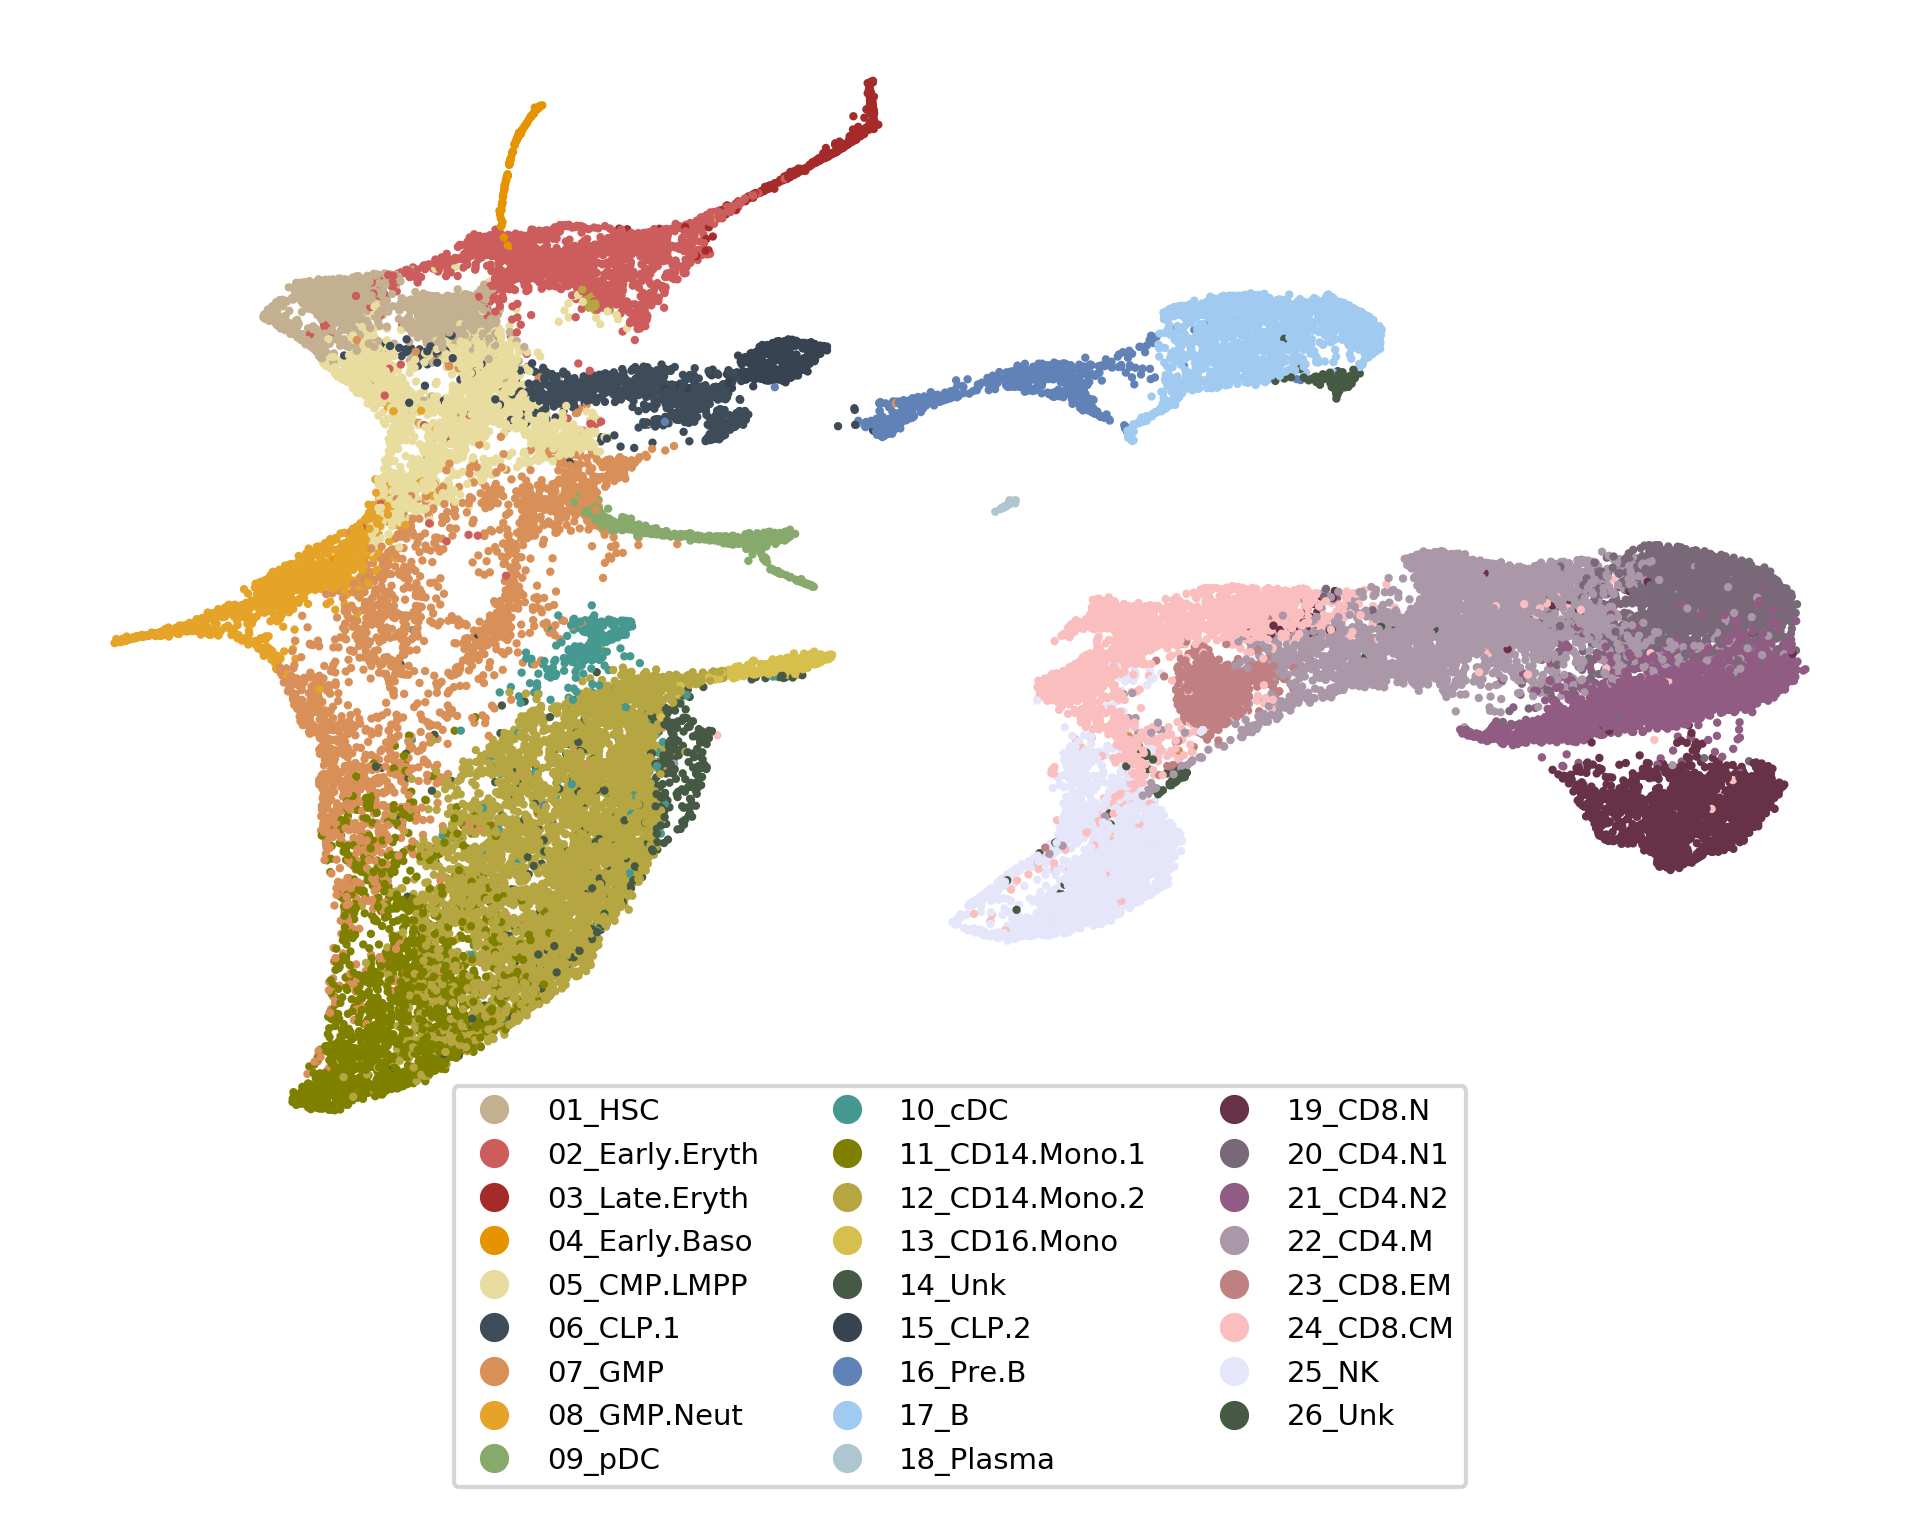

In [99]:
# create a color code for the biological labels
labels = metadata.set_index("group_barcode", drop=False
                           ).loc[data["combined"].f_barcodes2
                                ].BioClassification.values
coldict = dict(zip(np.unique(labels), colors))
color = labels
for l, c in coldict.items():
    color = [c if i == l else i for i in color]
legend = {k: coldict[k] for k in np.unique(labels)}
marker = [plt.Line2D([0,0], [0,0], color=c, marker="o", ls="")
          for c in legend.values()]

plt.figure(figsize=(8, 5), dpi=300)
plt.scatter(x=data["combined"].umap[:, 0], y=data["combined"].umap[:, 1],
            s=1, c=color)
plt.legend(marker, legend.keys(), numpoints=0.2, fontsize=7, ncol=3,
           loc="lower center", bbox_to_anchor=(0.5, -0.3))

ax = plt.axes()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.set_frame_on(False)

plt.show()

Lastly, we use a UMAP of the same parameters to save a 25D UMAP

In [100]:
data["combined"].umap25 = UMAP(n_components=25, n_neighbors=30,
                               min_dist=0.3, random_state=42
                              ).fit_transform(data["combined"].svd)
np.save("../processed/greenleaf_scRNA_combined_umap25.npy",
        data["combined"].umap25)

/home/hvlot/miniconda3/envs/hcv1/lib/python3.6/site-packages/numba/typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../../../home/hvlot/miniconda3/envs/hcv1/lib/python3.6/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  state.func_ir.loc))
